<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"></ul></div>

In [1]:
from query.datasets.prelude import *
from query.datasets.ingest import ingest_pose
import pyspark.sql.functions as func

In [2]:
data = '''Lindsey Graham,U.S. Senate South Carolina,2003,Republican Party,
Richard Burr,U.S. Senate North Carolina,Republican Party,
Pat Toomey,U.S. Senate Pennsylvania,2011,Republican Party,
Lamar Alexander,U.S. Senate Tennessee,2003,Republican Party,
Shelley Moore Capito,U.S. Senate West Virginia,Republican Party,
Bob Corker,U.S. Senate Tennessee,2007,Republican Party,
Todd C. Young,U.S. Senate Indiana,Republican Party,
Pat Roberts,U.S. Senate Kansas,1997,Republican Party,
Ben Sasse,U.S. Senate Nebraska,Republican Party,
Bill Cassidy,U.S. Senate Louisiana,2015,Republican Party,
John Neely Kennedy,U.S. Senate Louisiana,Republican Party,
Thom Tillis,U.S. Senate North Carolina,Republican Party,
David Perdue,U.S. Senate Georgia,Republican Party,
Orrin Hatch,U.S. Senate Utah,Republican Party,
Daniel S. Sullivan,U.S. Senate Alaska,Republican Party,
Chuck Grassley,U.S. Senate Iowa,1981,Republican Party,
Steve Daines,U.S. Senate Montana,Republican Party,
Jim Inhofe,U.S. Senate Oklahoma,1995,Republican Party,
Jerry Moran,U.S. Senate Kansas,2011,Republican Party,
Rob Portman,U.S. Senate Ohio,2011,Republican Party,
Ron Johnson,U.S. Senate Wisconsin,2010,Republican Party,
Jeff Flake,U.S. Senate Arizona,2013,Republican Party,
Susan Collins,U.S. Senate Maine,Republican Party,
Cory Gardner,U.S. Senate Colorado,2015,Republican Party,
Tom Cotton,U.S. Senate Arkansas,Republican Party,
Dean Heller,U.S. Senate Nevada,Republican Party,
Ted Cruz,U.S. Senate Texas,Republican Party,
John Barrasso,U.S. Senate Wyoming,2007,Republican Party,
Mike Lee,U.S. Senate Utah,2011,Republican Party,
John Cornyn,U.S. Senate Texas,2003-01-03,Republican Party,
Deb Fischer,U.S. Senate Nebraska,Republican Party,
Roy Blunt,U.S. Senate Missouri,Republican Party,
Mitch McConnell,U.S. Senate Kentucky,1985,Republican Party,
John McCain,U.S. Senate Arizona,1987,Republican Party,
John Boozman,U.S. Senate Arkansas,2011,Republican Party,
Mike Enzi,U.S. Senate Wyoming,1997,Republican Party,
Mike Crapo,U.S. Senate Idaho,Republican Party,
Roger Wicker,U.S. Senate Mississippi,Republican Party,
Joni Ernst,U.S. Senate Iowa,Republican Party,
John Thune,U.S. Senate South Dakota,2005,Republican Party,
Jim Risch,U.S. Senate Idaho,Republican Party,
John Hoeven,U.S. Senate North Dakota,2011,Republican Party,
Mike Rounds,U.S. Senate South Dakota,Republican Party,
Johnny Isakson,U.S. Senate Georgia,Republican Party,
Marco Rubio,U.S. Senate Florida,Republican Party,
Richard Shelby,U.S. Senate Alabama,1987,Republican Party,
Lisa Murkowski,U.S. Senate Alaska,2003,Republican Party,
Rand Paul,U.S. Senate Kentucky,2011,Republican Party,
Tim Scott,U.S. Senate South Carolina,2013,Republican Party,
James Lankford,U.S. Senate Oklahoma,Republican Party,
Cindy Hyde-Smith,U.S. Senate Mississippi,2018-04-01,Republican Party,
Angus King,U.S. Senate Maine,2013,Independent,
Bernie Sanders,U.S. Senate Vermont,2007,Independent,
Jack Reed,U.S. Senate Rhode Island,1997,Democratic Party,
Chris Coons,U.S. Senate Delaware,Democratic Party,
Gary Peters,U.S. Senate Michigan,Democratic Party,
Maggie Hassan,U.S. Senate New Hampshire,Democratic Party,
Bob Menendez,U.S. Senate New Jersey,Democratic Party,
Tammy Duckworth,U.S. Senate Illinois,Democratic Party,
Dick Durbin,U.S. Senate Illinois,Democratic Party,
Mark Warner,U.S. Senate Virginia,Democratic Party,
Doug Jones,U.S. Senate Alabama,Democratic Party,
Brian E. Schatz,U.S. Senate Hawaii,2012,Democratic Party,
Chuck Schumer,U.S. Senate New York,Democratic Party,
Chris Van Hollen,U.S. Senate Maryland,Democratic Party,Chris Van Hollen
Michael Bennet,U.S. Senate Colorado,2009,Democratic Party,
Jeff Merkley,U.S. Senate Oregon,2009,Democratic Party,
Jeanne Shaheen,U.S. Senate New Hampshire,Democratic Party,
Ron Wyden,U.S. Senate Oregon,Democratic Party,
Tina Smith,U.S. Senate Minnesota,2018,Democratic Party,
Christopher S. Murphy,U.S. Senate Connecticut,Democratic Party,Chris Murphy
Tom Carper,U.S. Senate Delaware,Democratic Party,
Bill Nelson,U.S. Senate Florida,Democratic Party,
Mazie K. Hirono,U.S. Senate Hawaii,Democratic Party,
Joe Donnelly,U.S. Senate Indiana,2013-01-03,Democratic Party,
Tom Udall,U.S. Senate New Mexico,Democratic Party,
Debbie Stabenow,U.S. Senate Michigan,Democratic Party,
Amy Klobuchar,U.S. Senate Minnesota,Democratic Party,
Claire McCaskill,U.S. Senate Missouri,Democratic Party,
Martin Heinrich,U.S. Senate New Mexico,Democratic Party,
Kirsten Gillibrand,U.S. Senate New York,Democratic Party,
Heidi Heitkamp,U.S. Senate North Dakota,Democratic Party,
Bob Casey Jr.,U.S. Senate Pennsylvania,2007,Democratic Party,Bob Casey
Maria Cantwell,U.S. Senate Washington,2001,Democratic Party,
Tammy Baldwin,U.S. Senate Wisconsin,Democratic Party,
Ben Cardin,U.S. Senate Maryland,2007,Democratic Party,
Dianne Feinstein,U.S. Senate California,1992,Democratic Party,
Jon Tester,U.S. Senate Montana,Democratic Party,
Sherrod Brown,U.S. Senate Ohio,2007,Democratic Party,
Cory Booker,U.S. Senate New Jersey,Democratic Party,
Kamala D. Harris,U.S. Senate California,Democratic Party,
Catherine Cortez Masto,U.S. Senate Nevada,Democratic Party,
Elizabeth Warren,U.S. Senate Massachusetts,2013-01-03,Democratic Party,
Tim Kaine,U.S. Senate Virginia,Democratic Party,
Joe Manchin III,U.S. Senate West Virginia,Democratic Party,Joe Manchin
Patrick Leahy,U.S. Senate Vermont,Democratic Party,
Ed Markey,U.S. Senate Massachusetts,Democratic Party,
Richard Blumenthal,U.S. Senate Connecticut,Democratic Party,
Sheldon Whitehouse,U.S. Senate Rhode Island,2007,Democratic Party,
Patty Murray,U.S. Senate Washington,1993,Democratic Party,
'''

In [3]:
def remove_middle_name(name):
    tokens = name.split(' ')
    if len(tokens) == 2:
        return tokens[0], tokens[1]
    elif len(tokens) == 3:
        if tokens[1] == 'Van':
            return tokens[0], tokens[1] + ' ' + tokens[2]
        else:
            return tokens[0], tokens[2]
    else:
        raise NotImplementedError('cannot handle {}'.format(name))

senators = []
senators_meta = {}
for line in data.split('\n'):
    line = line.strip()
    if line == '':
        continue
    tokens = line.split(',')
    if len(tokens) == 5:
        name, state, _, party, alt_name = tokens
    else:
        name, state, party, alt_name = tokens
    if alt_name:
        first, last = remove_middle_name(alt_name)
    else:
        first, last = remove_middle_name(name)
    senators.append((first, last))
    senators_meta[(first, last)] = (state, party)
senators.sort()

In [4]:
senator_to_videos_ids = {}
for senator in senators:
    first, last = senator
    video_ids = set()
    result = caption_search([(first + ' ' + last).upper()])
    video_ids.update(result[0].keys())
    result = caption_search([('senator ' + last).upper()])
    video_ids.update(result[0].keys())
    senator_to_videos_ids[senator] = video_ids
    print(senator, len(video_ids))

('Amy', 'Klobuchar') 255
('Angus', 'King') 411
('Ben', 'Cardin') 267
('Ben', 'Sasse') 440
('Bernie', 'Sanders') 17887
('Bill', 'Cassidy') 536
('Bill', 'Nelson') 229
('Bob', 'Casey') 229
('Bob', 'Corker') 2596
('Bob', 'Menendez') 523
('Brian', 'Schatz') 41
('Catherine', 'Masto') 3
('Chris', 'Coons') 369
('Chris', 'Murphy') 708
('Chris', 'Van Hollen') 104
('Chuck', 'Grassley') 1339
('Chuck', 'Schumer') 5668
('Cindy', 'Hyde-Smith') 0
('Claire', 'McCaskill') 33
('Cory', 'Booker') 812
('Cory', 'Gardner') 239
('Daniel', 'Sullivan') 18
('David', 'Perdue') 79
('Dean', 'Heller') 613
('Deb', 'Fischer') 12
('Debbie', 'Stabenow') 61
('Dianne', 'Feinstein') 1449
('Dick', 'Durbin') 532
('Doug', 'Jones') 826
('Ed', 'Markey') 140
('Elizabeth', 'Warren') 4674
('Gary', 'Peters') 42
('Heidi', 'Heitkamp') 157
('Jack', 'Reed') 158
('James', 'Lankford') 90
('Jeanne', 'Shaheen') 99
('Jeff', 'Flake') 1645
('Jeff', 'Merkley') 208
('Jerry', 'Moran') 115
('Jim', 'Inhofe') 46
('Jim', 'Risch') 72
('Joe', 'Donnelly

In [5]:
def get_count_for_show(show_name, video_ids):
    return Video.objects.filter(show__name=show_name, id__in=video_ids).count()

In [6]:
shows = [
    'MSNBC Live',
    'CNN Newsroom Live',
    'Americas News HQ',
    'FOX  Friends',
    'The OReilly Factor',
    'Tucker Carlson Tonight',
    'The Rachel Maddow Show',
]
for senator in senators:
    print(senator)
    for show_name in shows:
        print('\t', show_name, get_count_for_show(show_name, senator_to_videos_ids[senator]))

('Amy', 'Klobuchar')
	 MSNBC Live 11
	 CNN Newsroom Live 1
	 Americas News HQ 1
	 FOX  Friends 1
	 The OReilly Factor 1
	 Tucker Carlson Tonight 0
	 The Rachel Maddow Show 29
('Angus', 'King')
	 MSNBC Live 10
	 CNN Newsroom Live 1
	 Americas News HQ 6
	 FOX  Friends 3
	 The OReilly Factor 0
	 Tucker Carlson Tonight 2
	 The Rachel Maddow Show 19
('Ben', 'Cardin')
	 MSNBC Live 12
	 CNN Newsroom Live 0
	 Americas News HQ 5
	 FOX  Friends 5
	 The OReilly Factor 1
	 Tucker Carlson Tonight 0
	 The Rachel Maddow Show 5
('Ben', 'Sasse')
	 MSNBC Live 29
	 CNN Newsroom Live 4
	 Americas News HQ 9
	 FOX  Friends 14
	 The OReilly Factor 6
	 Tucker Carlson Tonight 3
	 The Rachel Maddow Show 6
('Bernie', 'Sanders')
	 MSNBC Live 788
	 CNN Newsroom Live 230
	 Americas News HQ 221
	 FOX  Friends 318
	 The OReilly Factor 399
	 Tucker Carlson Tonight 140
	 The Rachel Maddow Show 632
('Bill', 'Cassidy')
	 MSNBC Live 21
	 CNN Newsroom Live 5
	 Americas News HQ 18
	 FOX  Friends 17
	 The OReilly Factor 0
	 

	 MSNBC Live 5
	 CNN Newsroom Live 1
	 Americas News HQ 68
	 FOX  Friends 91
	 The OReilly Factor 88
	 Tucker Carlson Tonight 9
	 The Rachel Maddow Show 8
('John', 'Thune')
	 MSNBC Live 9
	 CNN Newsroom Live 0
	 Americas News HQ 6
	 FOX  Friends 2
	 The OReilly Factor 0
	 Tucker Carlson Tonight 1
	 The Rachel Maddow Show 11
('Johnny', 'Isakson')
	 MSNBC Live 0
	 CNN Newsroom Live 0
	 Americas News HQ 2
	 FOX  Friends 1
	 The OReilly Factor 0
	 Tucker Carlson Tonight 0
	 The Rachel Maddow Show 1
('Jon', 'Tester')
	 MSNBC Live 4
	 CNN Newsroom Live 1
	 Americas News HQ 3
	 FOX  Friends 3
	 The OReilly Factor 0
	 Tucker Carlson Tonight 0
	 The Rachel Maddow Show 9
('Joni', 'Ernst')
	 MSNBC Live 26
	 CNN Newsroom Live 4
	 Americas News HQ 3
	 FOX  Friends 11
	 The OReilly Factor 2
	 Tucker Carlson Tonight 0
	 The Rachel Maddow Show 17
('Kamala', 'Harris')
	 MSNBC Live 9
	 CNN Newsroom Live 1
	 Americas News HQ 3
	 FOX  Friends 3
	 The OReilly Factor 0
	 Tucker Carlson Tonight 1
	 The Rache

	 The OReilly Factor 11
	 Tucker Carlson Tonight 20
	 The Rachel Maddow Show 43
('Tom', 'Udall')
	 MSNBC Live 1
	 CNN Newsroom Live 0
	 Americas News HQ 0
	 FOX  Friends 0
	 The OReilly Factor 2
	 Tucker Carlson Tonight 0
	 The Rachel Maddow Show 3


('Amy', 'Klobuchar') ('U.S. Senate Minnesota', 'Democratic Party')


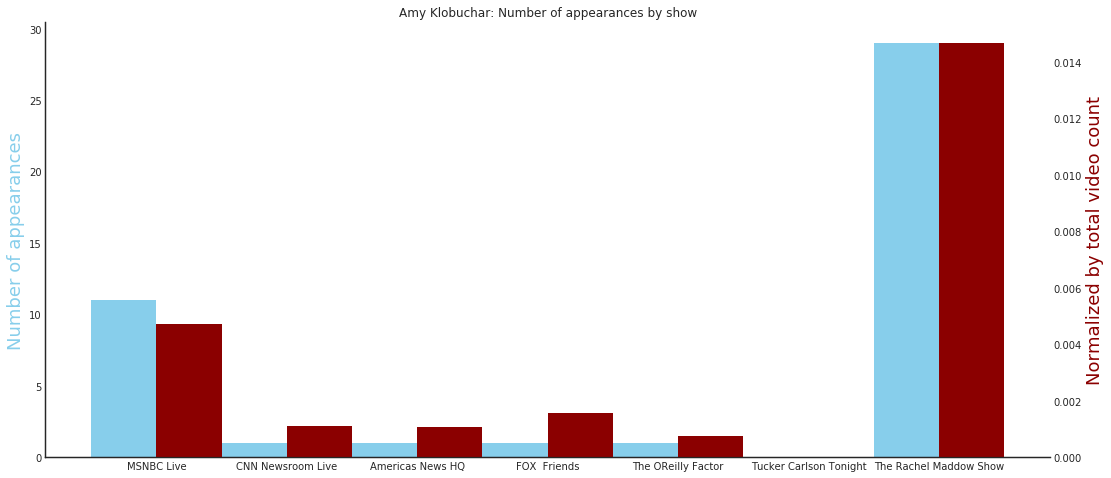

('Angus', 'King') ('U.S. Senate Maine', 'Independent')


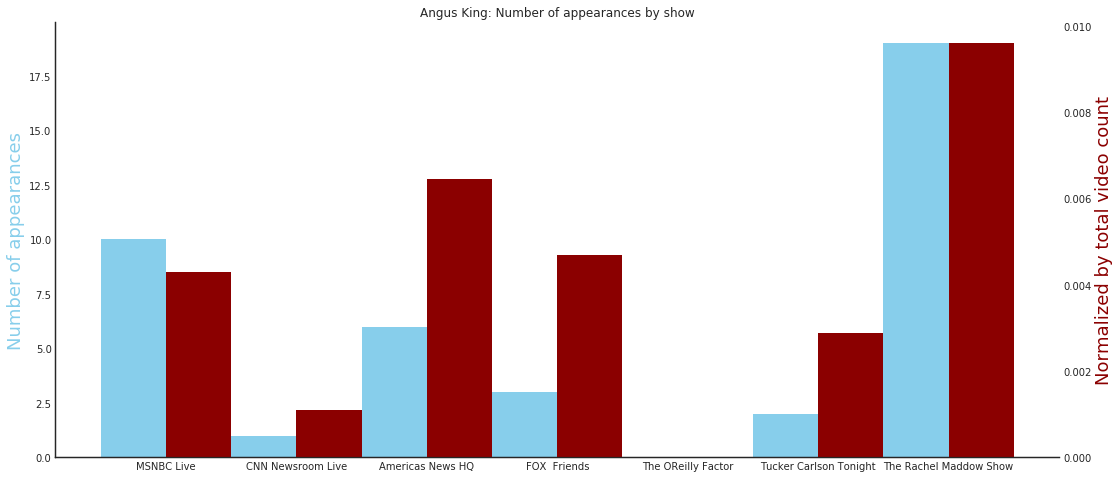

('Ben', 'Cardin') ('U.S. Senate Maryland', 'Democratic Party')


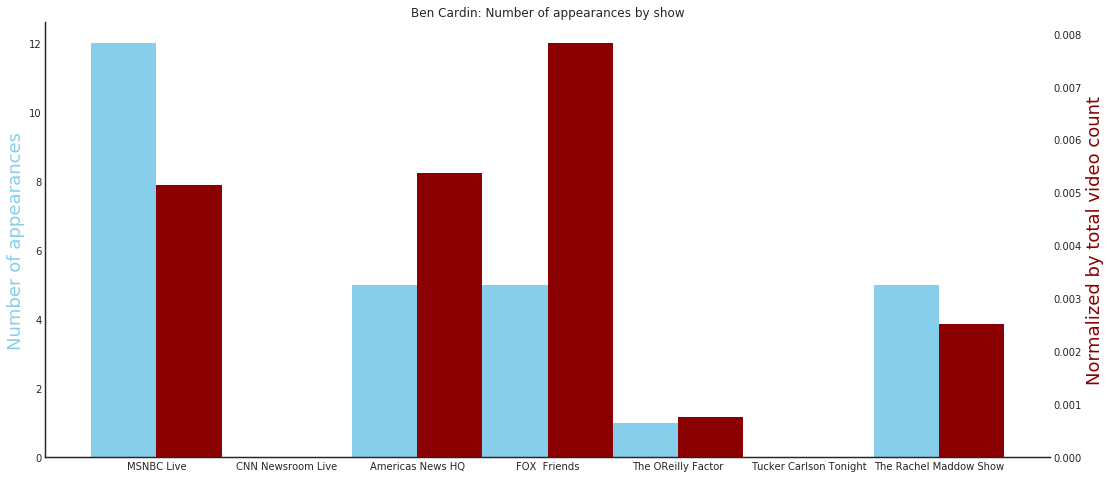

('Ben', 'Sasse') ('U.S. Senate Nebraska', 'Republican Party')


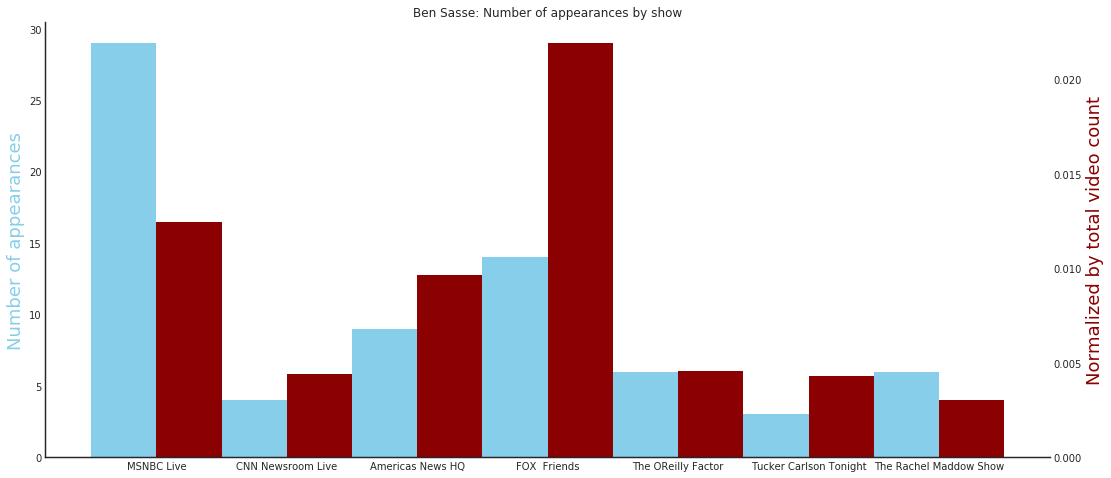

('Bernie', 'Sanders') ('U.S. Senate Vermont', 'Independent')


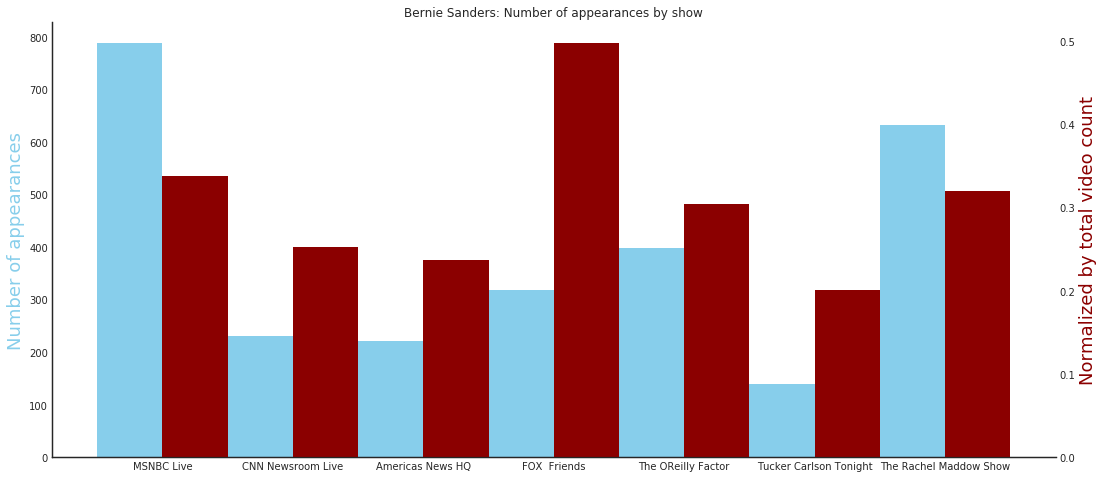

('Bill', 'Cassidy') ('U.S. Senate Louisiana', 'Republican Party')


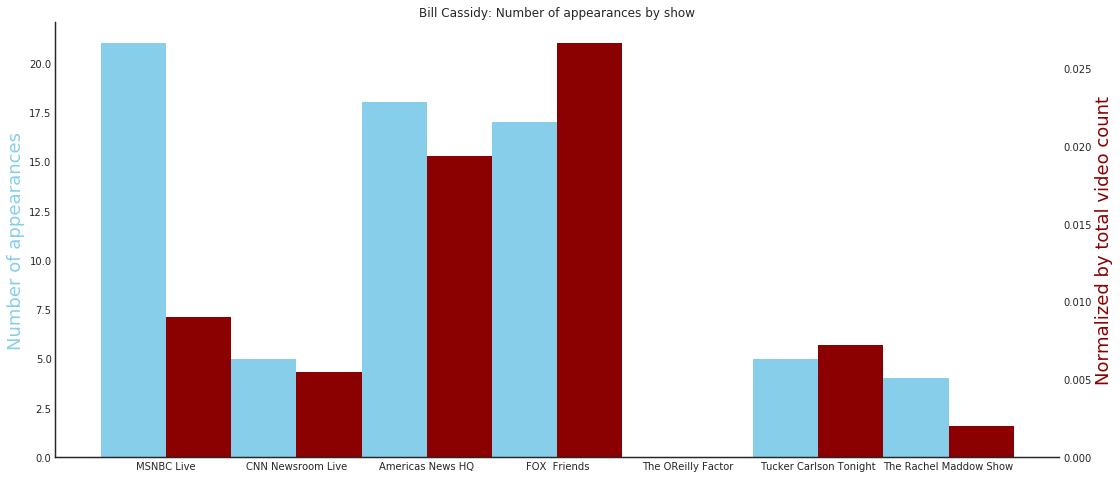

('Bill', 'Nelson') ('U.S. Senate Florida', 'Democratic Party')


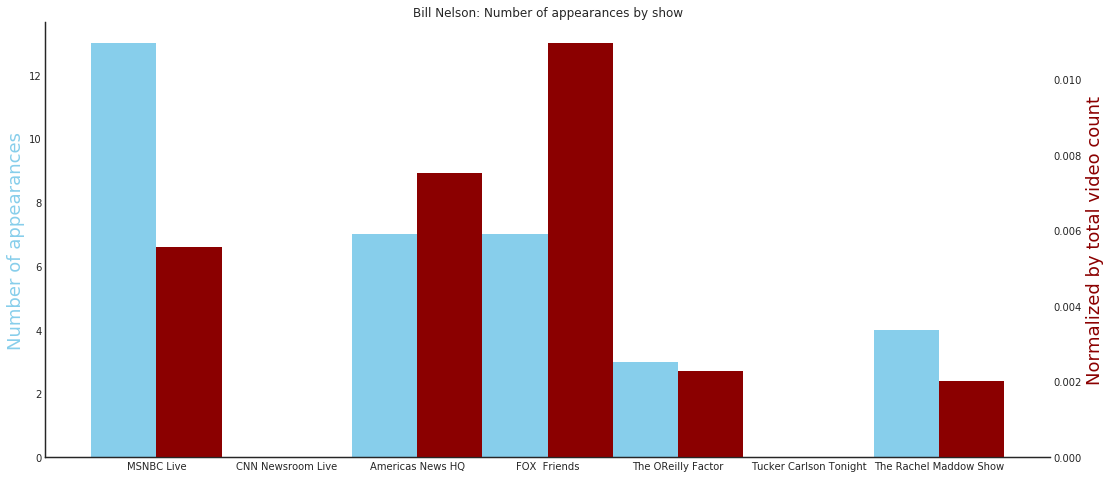

('Bob', 'Casey') ('U.S. Senate Pennsylvania', 'Democratic Party')


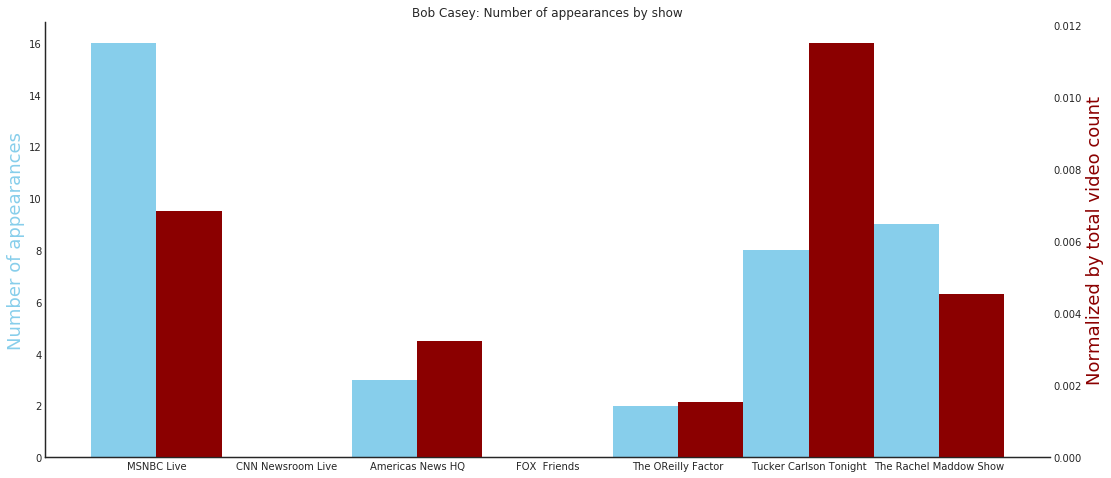

('Bob', 'Corker') ('U.S. Senate Tennessee', 'Republican Party')


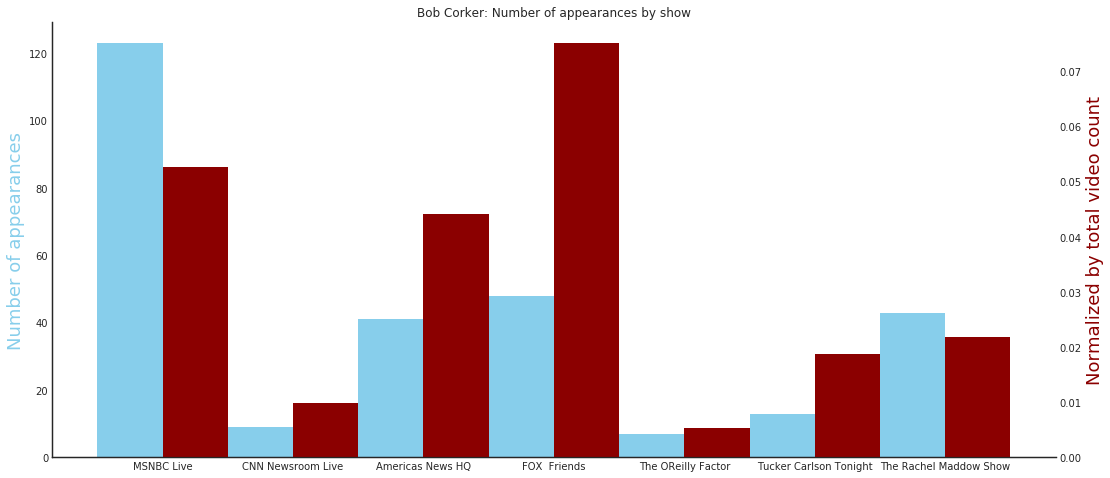

('Bob', 'Menendez') ('U.S. Senate New Jersey', 'Democratic Party')


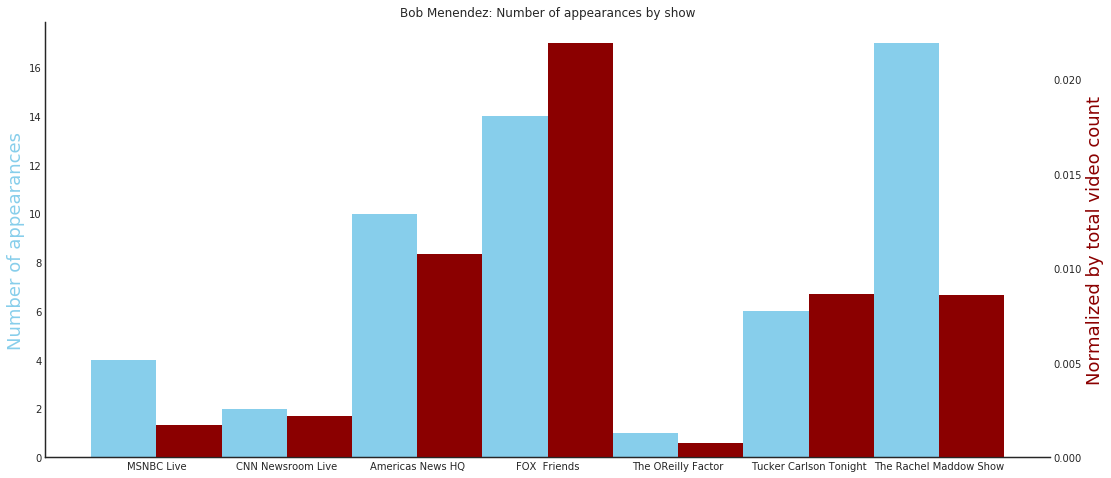

('Brian', 'Schatz') ('U.S. Senate Hawaii', 'Democratic Party')


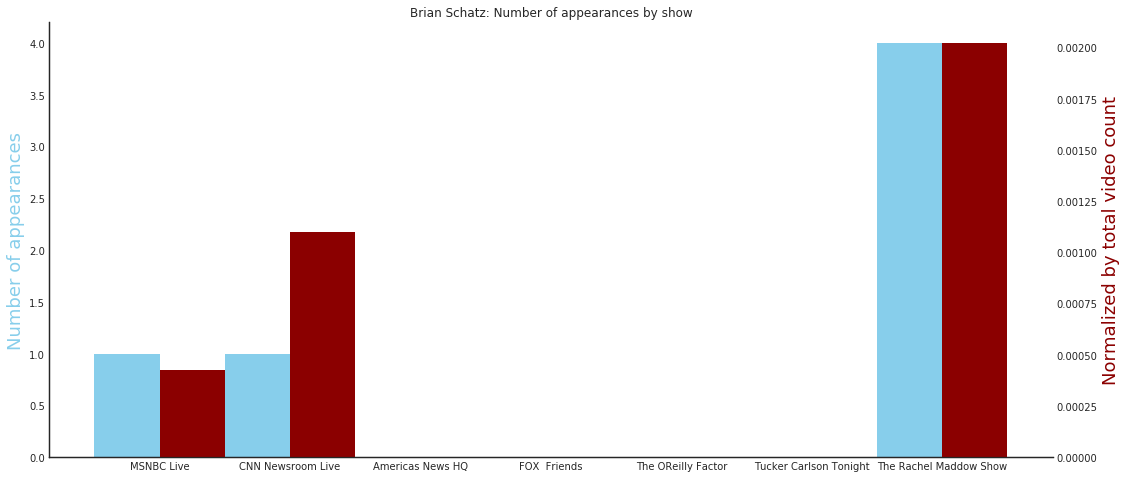

('Catherine', 'Masto') ('U.S. Senate Nevada', 'Democratic Party')


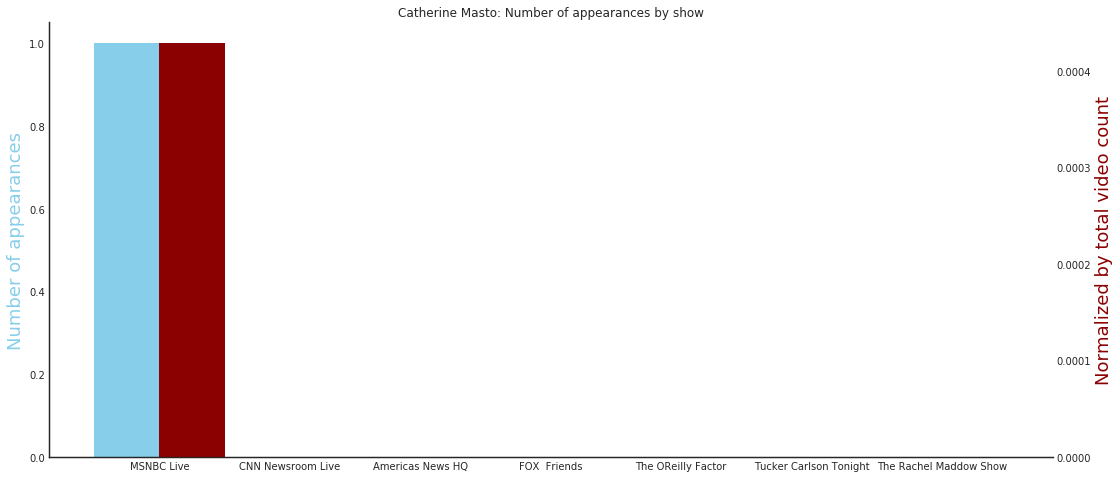

('Chris', 'Coons') ('U.S. Senate Delaware', 'Democratic Party')


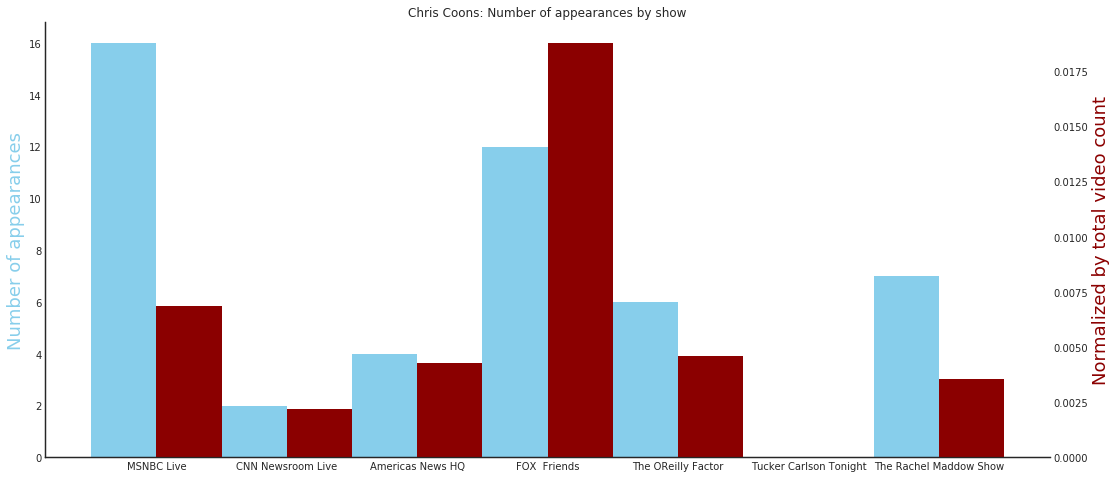

('Chris', 'Murphy') ('U.S. Senate Connecticut', 'Democratic Party')


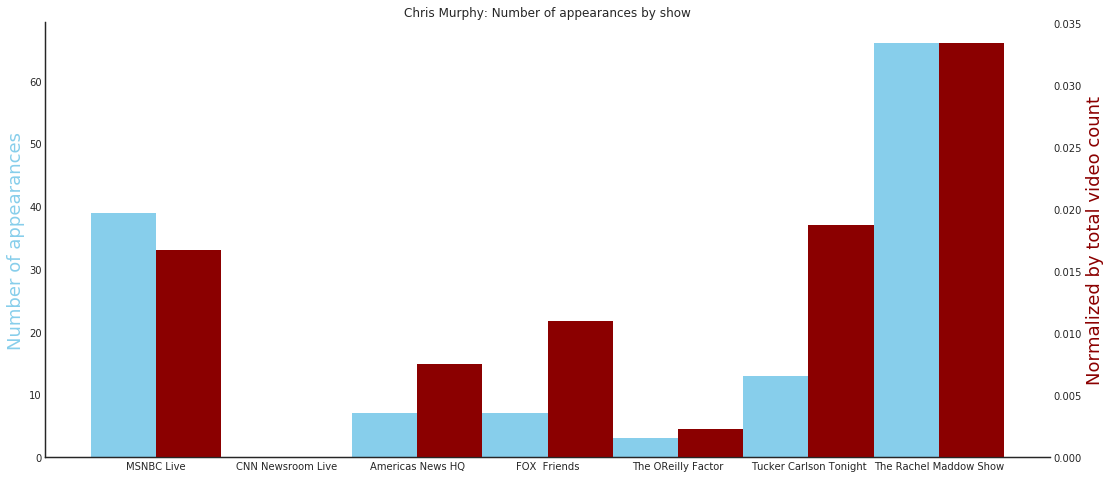

('Chris', 'Van Hollen') ('U.S. Senate Maryland', 'Democratic Party')


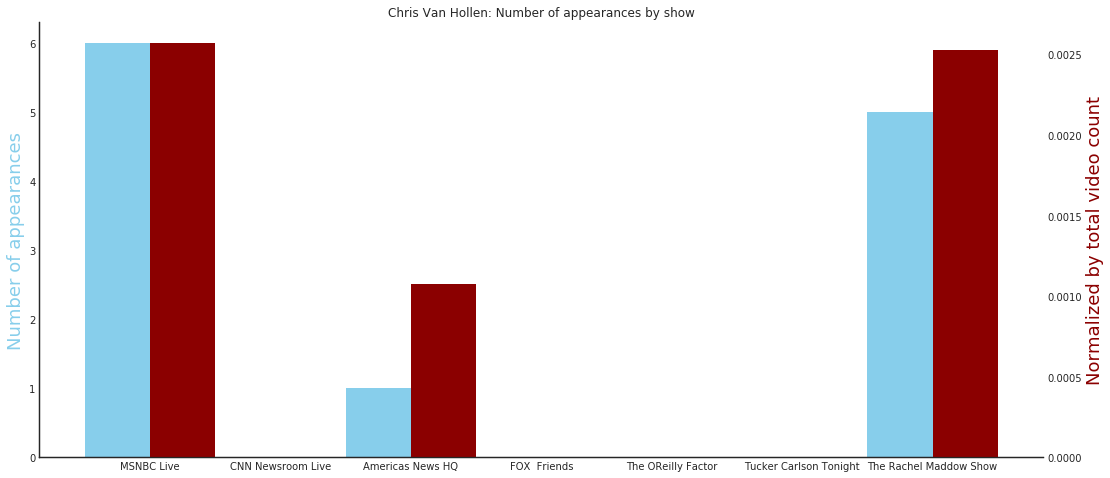

('Chuck', 'Grassley') ('U.S. Senate Iowa', 'Republican Party')


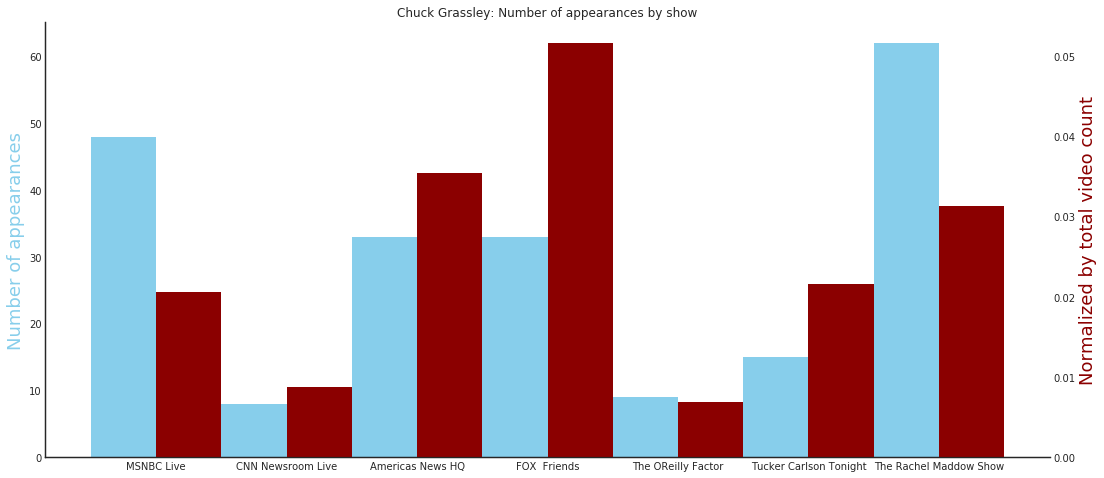

('Chuck', 'Schumer') ('U.S. Senate New York', 'Democratic Party')


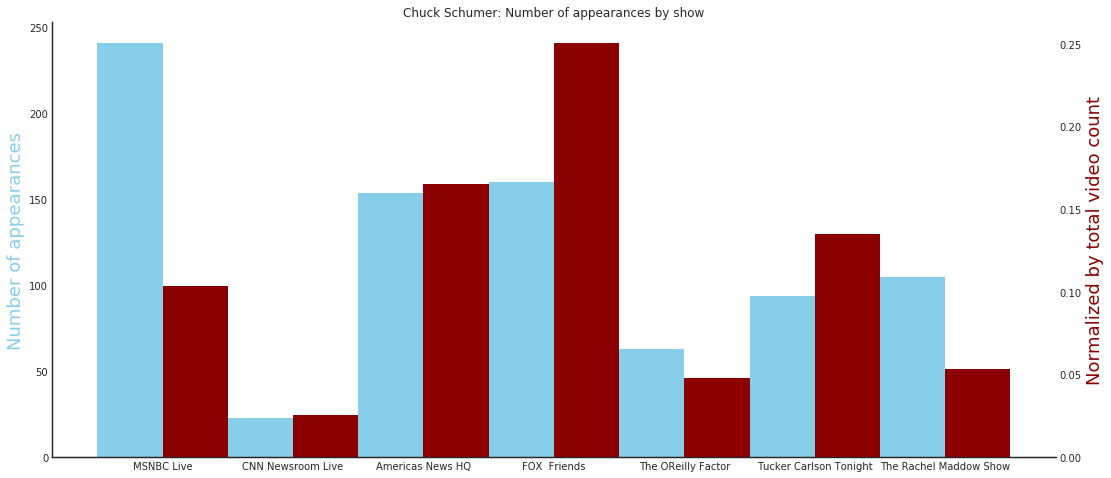

('Cindy', 'Hyde-Smith') ('U.S. Senate Mississippi', 'Republican Party')


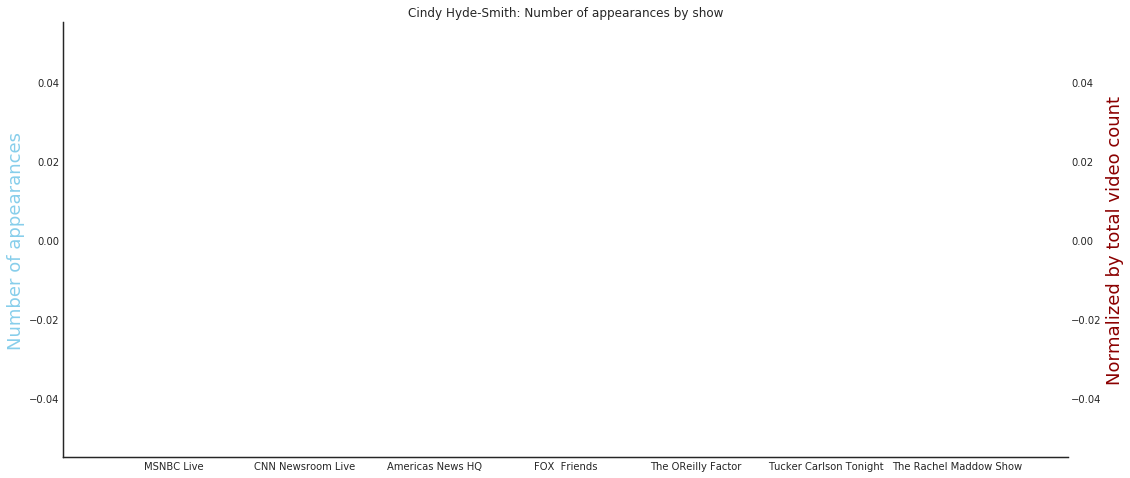

('Claire', 'McCaskill') ('U.S. Senate Missouri', 'Democratic Party')


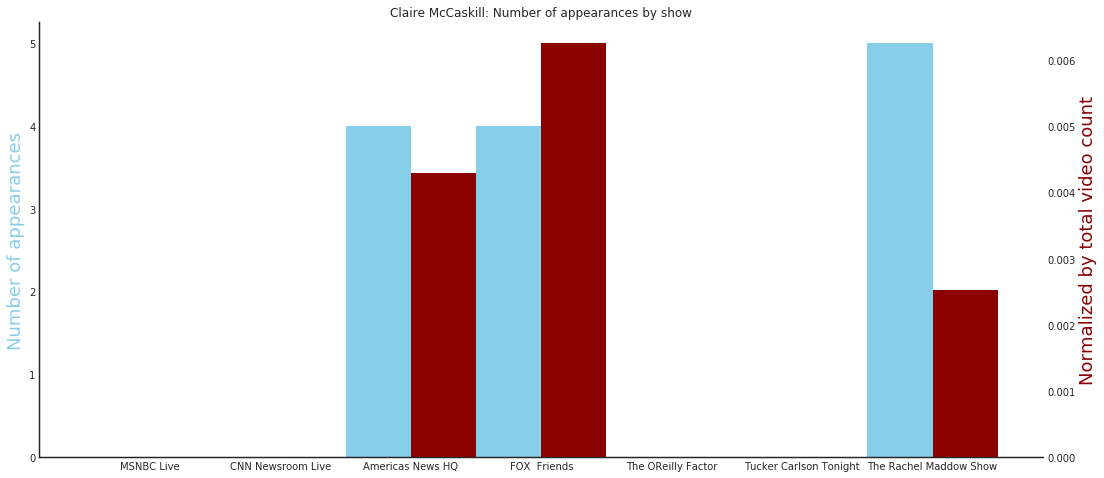

('Cory', 'Booker') ('U.S. Senate New Jersey', 'Democratic Party')


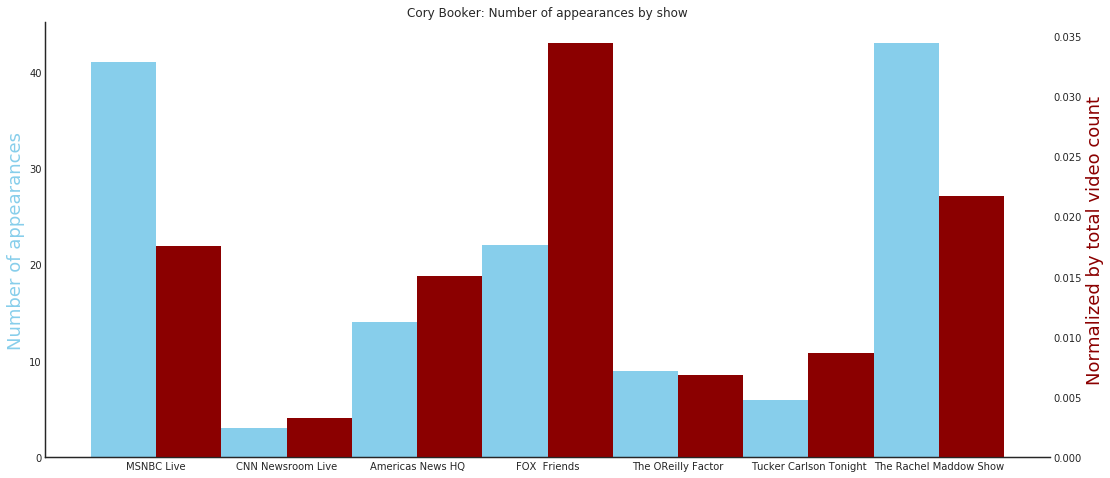

('Cory', 'Gardner') ('U.S. Senate Colorado', 'Republican Party')


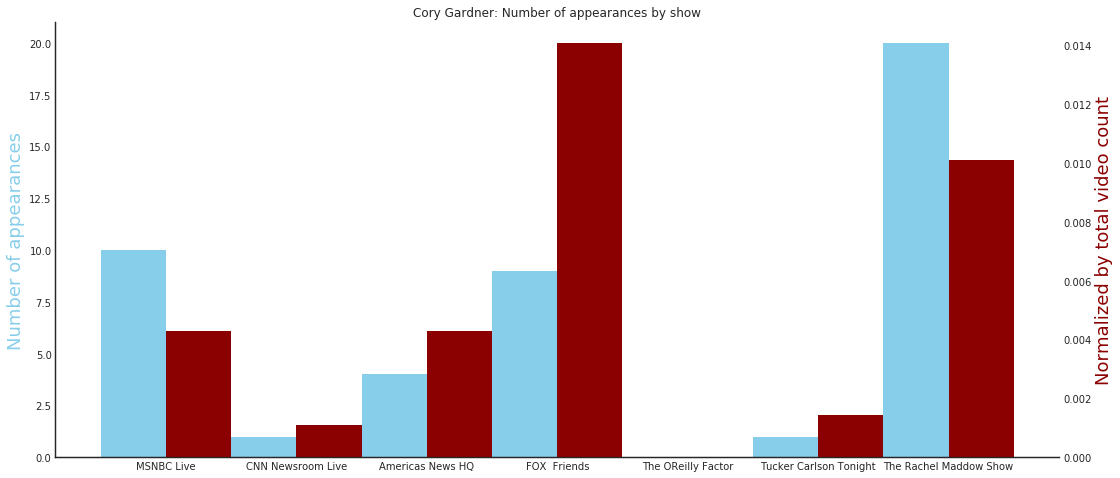

('Daniel', 'Sullivan') ('U.S. Senate Alaska', 'Republican Party')


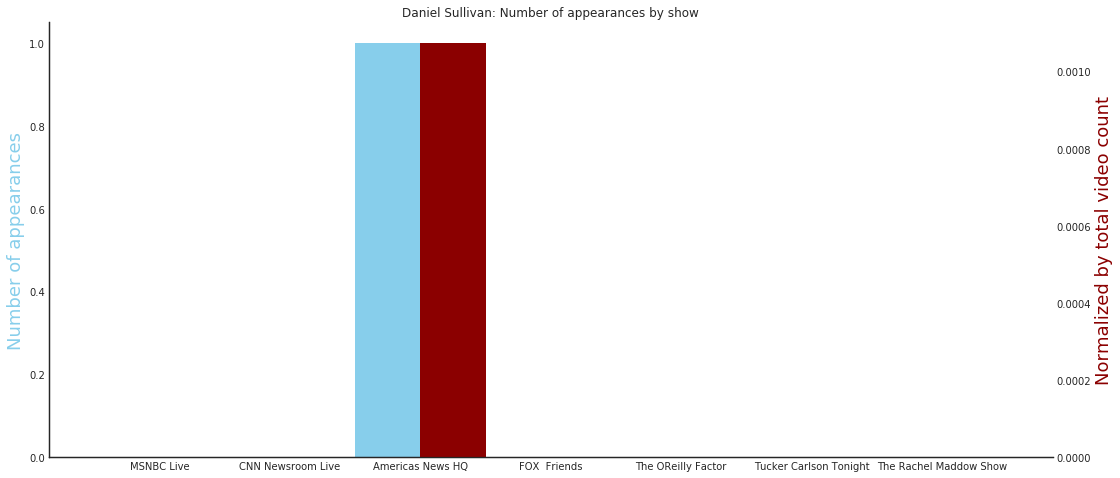

('David', 'Perdue') ('U.S. Senate Georgia', 'Republican Party')


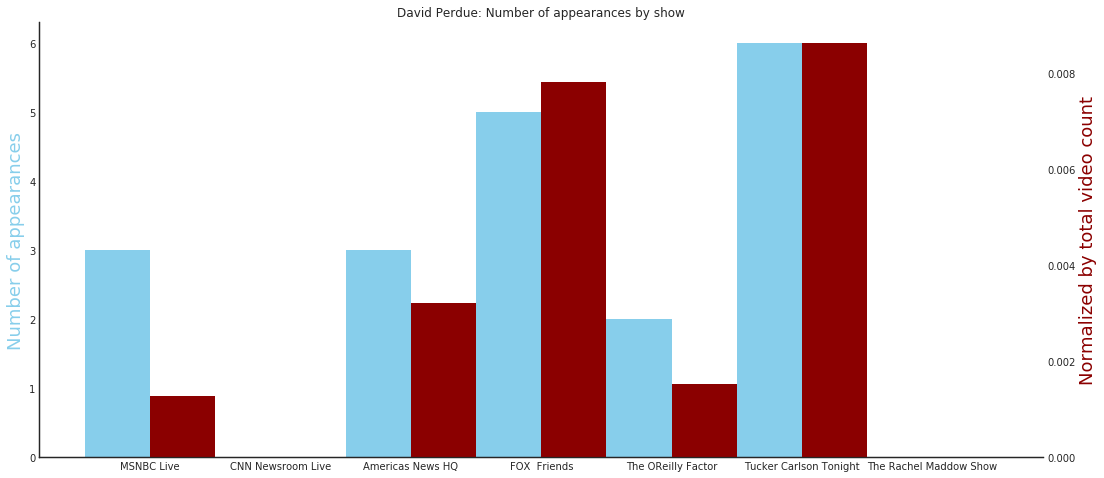

('Dean', 'Heller') ('U.S. Senate Nevada', 'Republican Party')


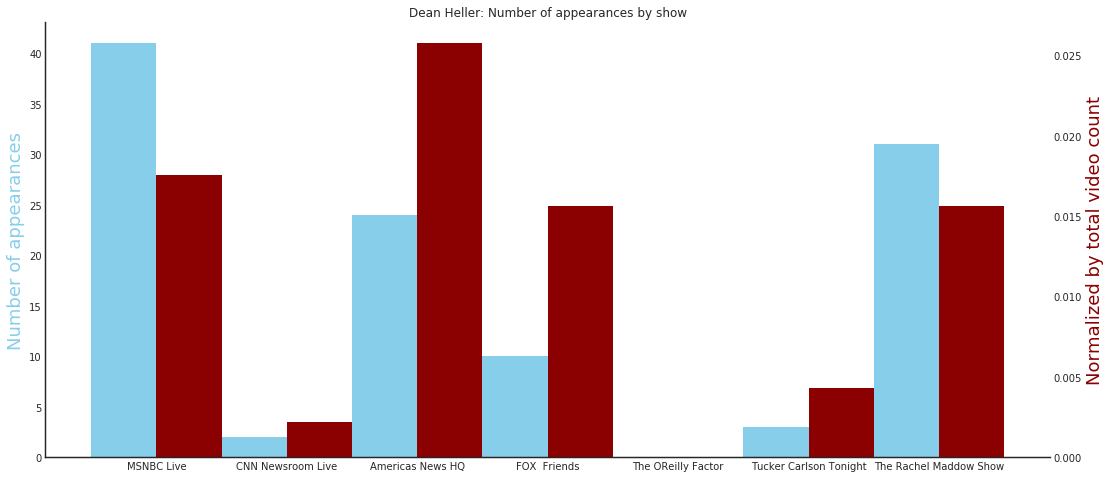

('Deb', 'Fischer') ('U.S. Senate Nebraska', 'Republican Party')


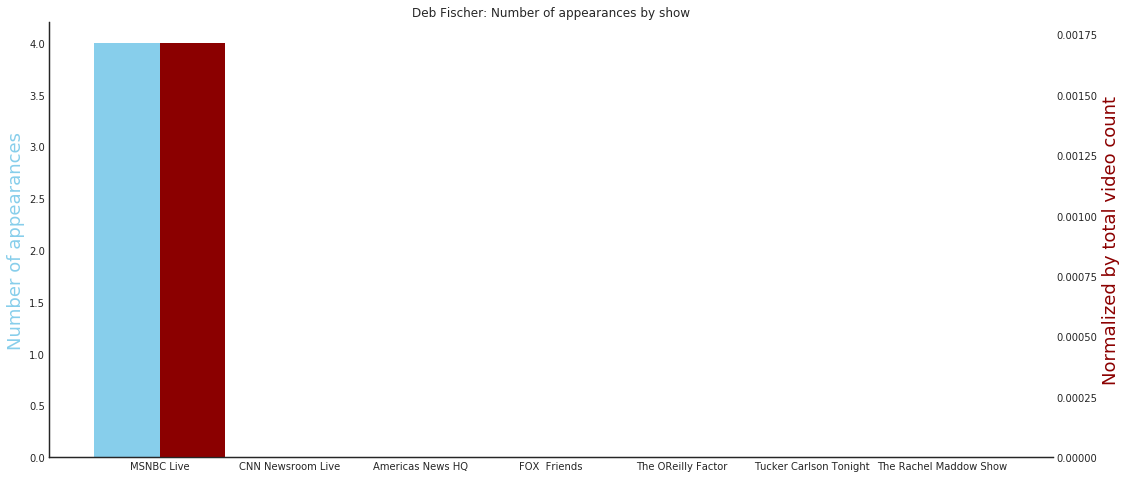

('Debbie', 'Stabenow') ('U.S. Senate Michigan', 'Democratic Party')


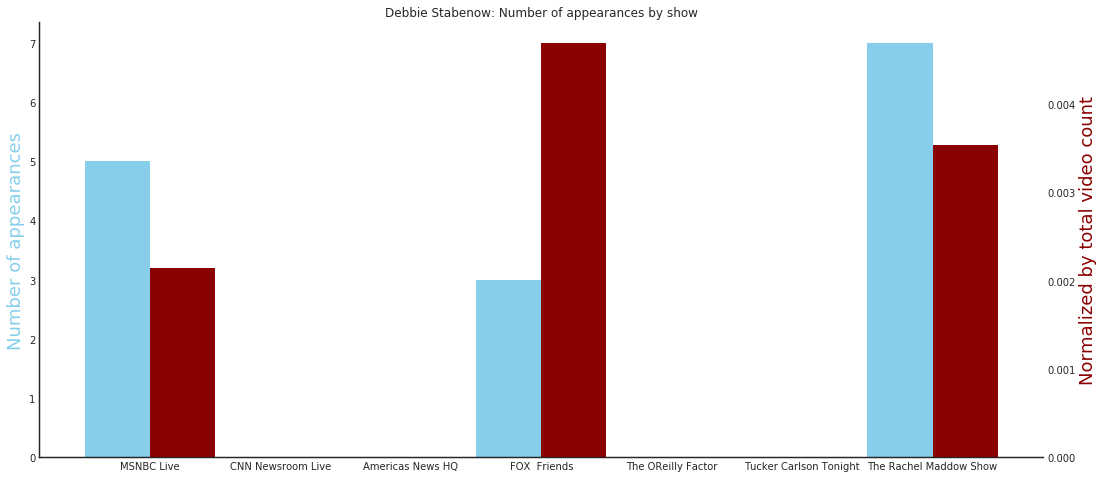

('Dianne', 'Feinstein') ('U.S. Senate California', 'Democratic Party')


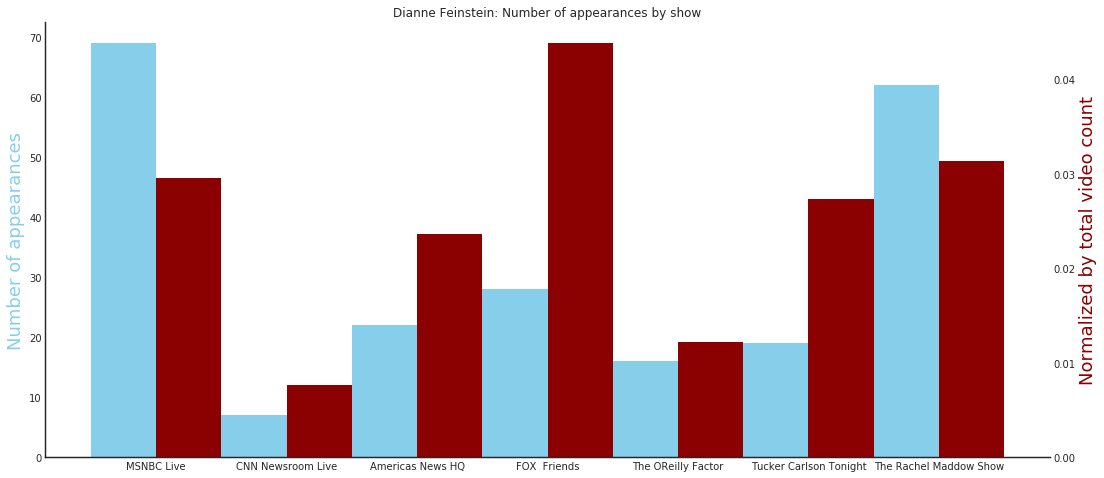

('Dick', 'Durbin') ('U.S. Senate Illinois', 'Democratic Party')


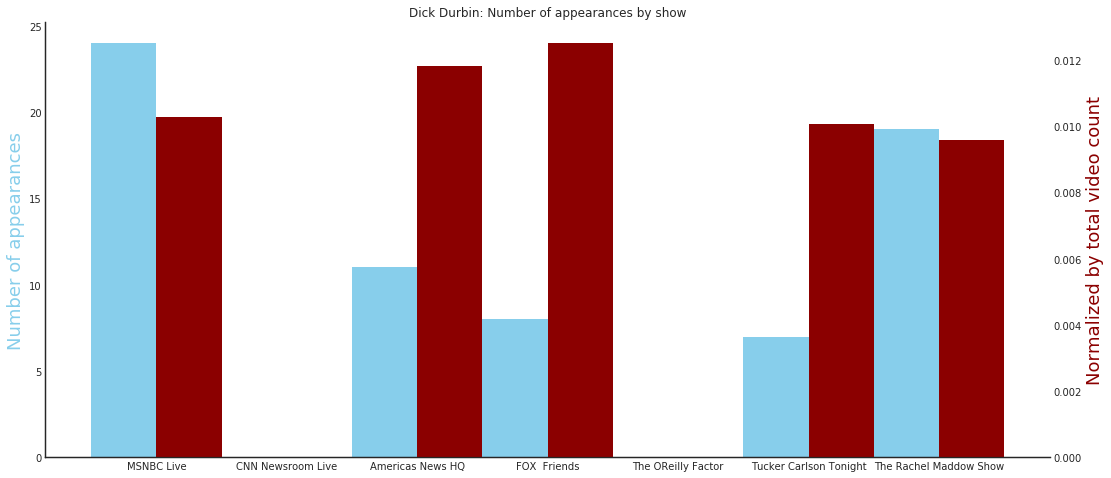

('Doug', 'Jones') ('U.S. Senate Alabama', 'Democratic Party')


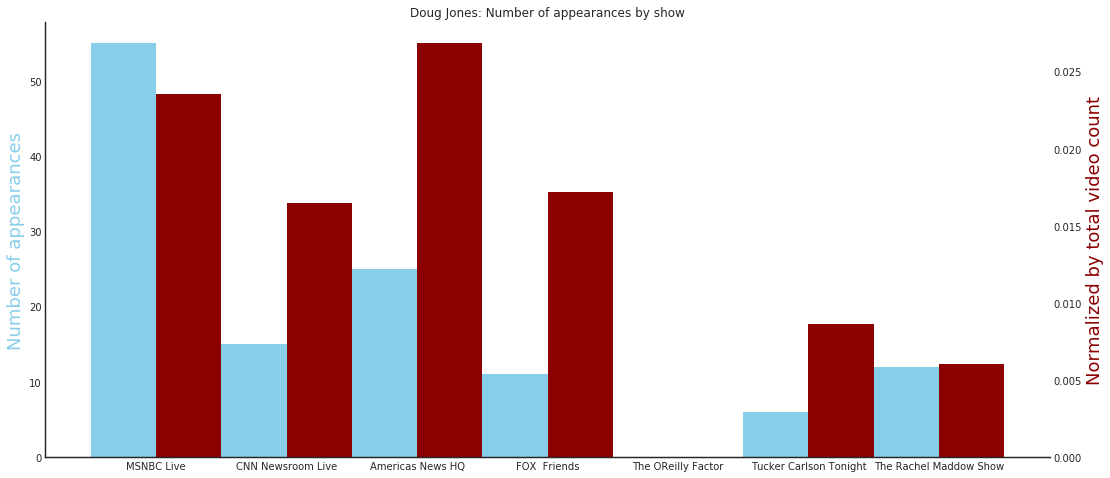

('Ed', 'Markey') ('U.S. Senate Massachusetts', 'Democratic Party')


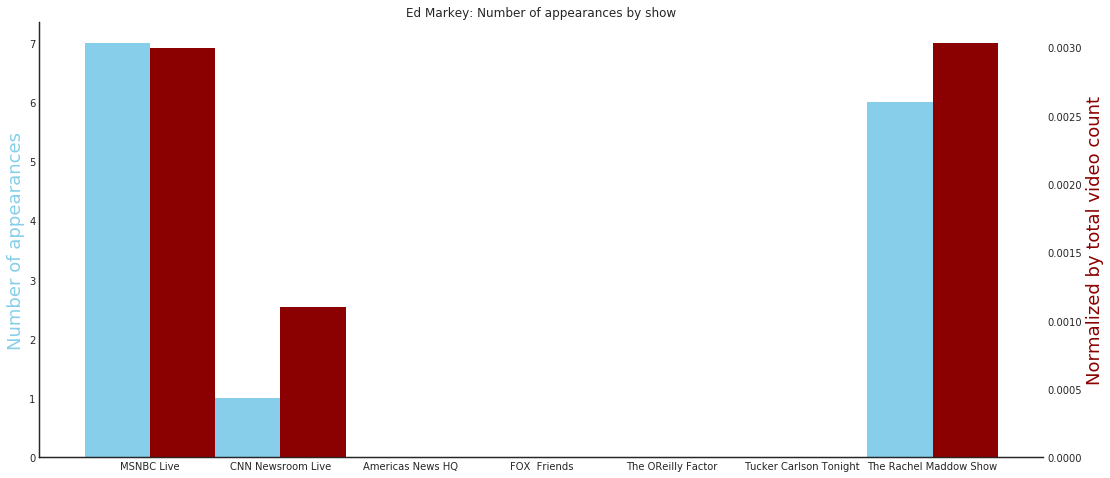

('Elizabeth', 'Warren') ('U.S. Senate Massachusetts', 'Democratic Party')


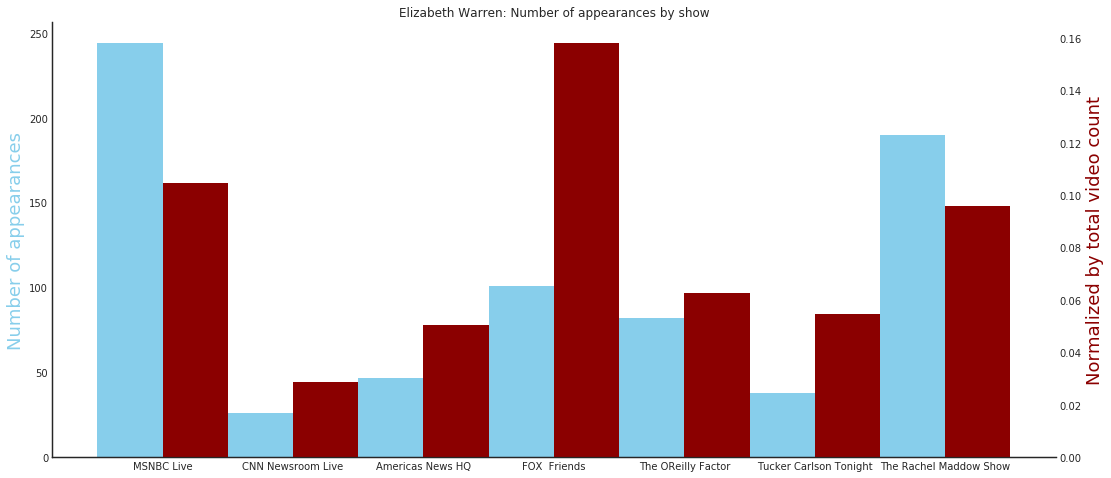

('Gary', 'Peters') ('U.S. Senate Michigan', 'Democratic Party')


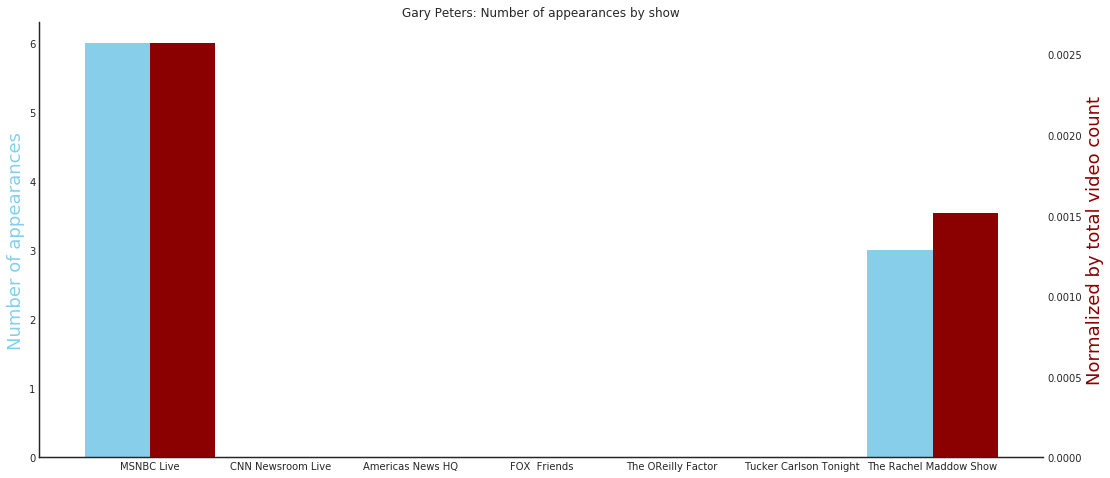

('Heidi', 'Heitkamp') ('U.S. Senate North Dakota', 'Democratic Party')


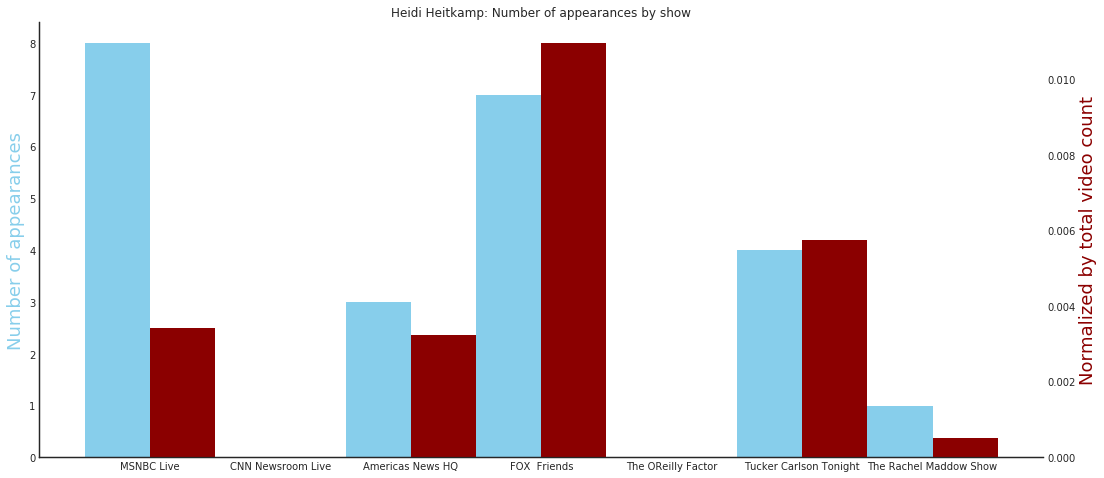

('Jack', 'Reed') ('U.S. Senate Rhode Island', 'Democratic Party')


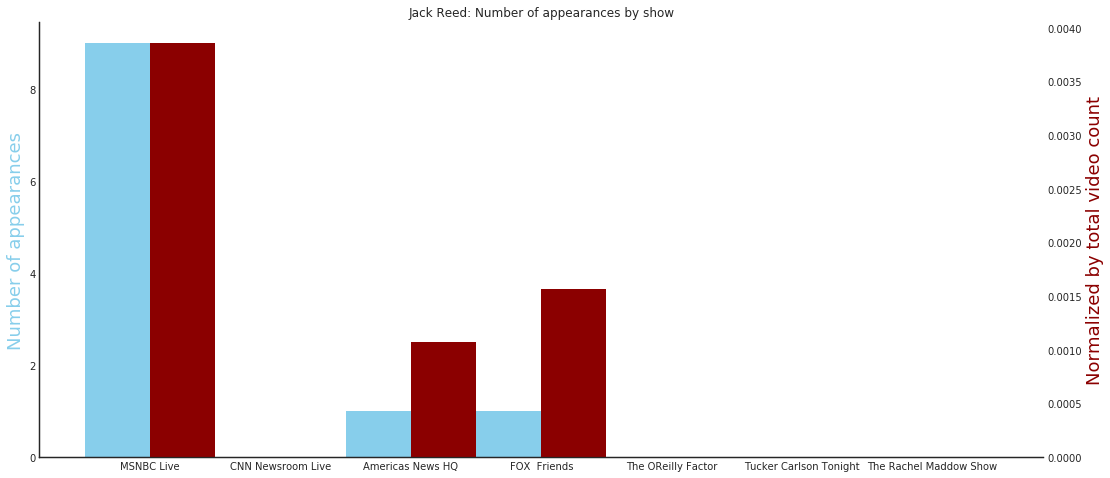

('James', 'Lankford') ('U.S. Senate Oklahoma', 'Republican Party')


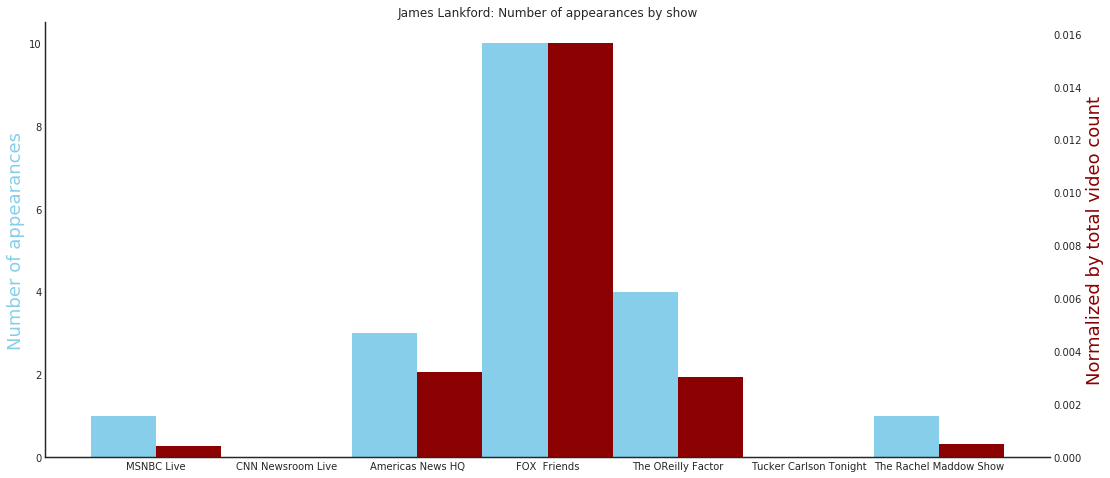

('Jeanne', 'Shaheen') ('U.S. Senate New Hampshire', 'Democratic Party')


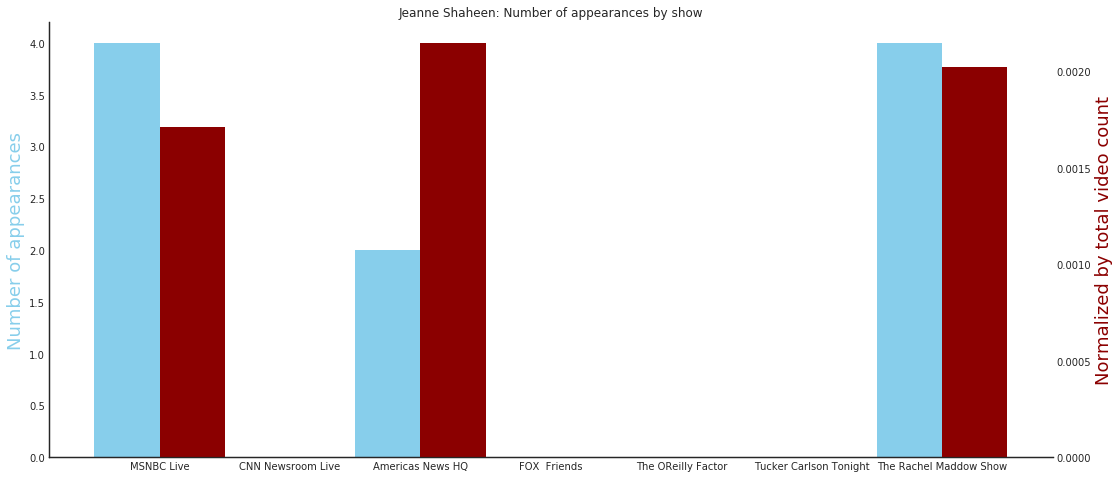

('Jeff', 'Flake') ('U.S. Senate Arizona', 'Republican Party')


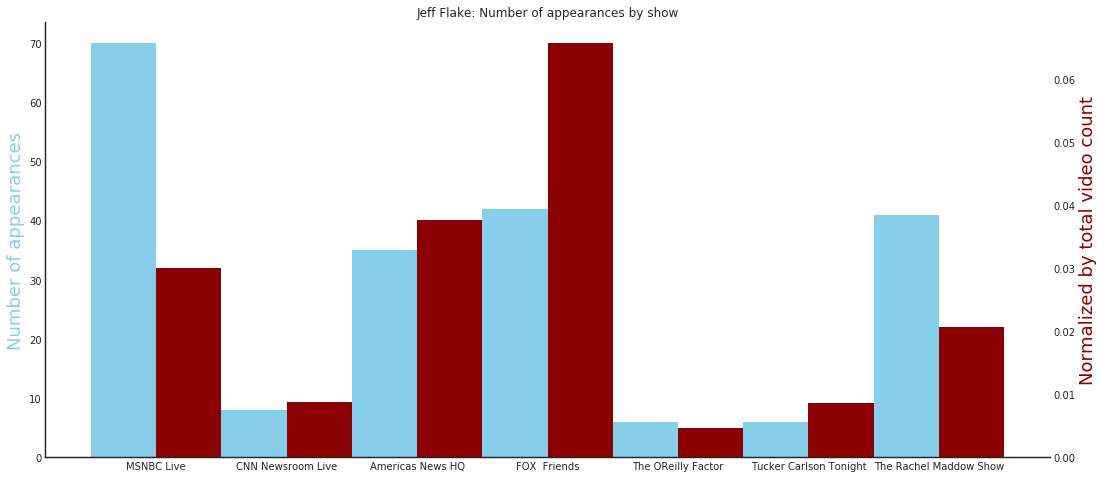

('Jeff', 'Merkley') ('U.S. Senate Oregon', 'Democratic Party')


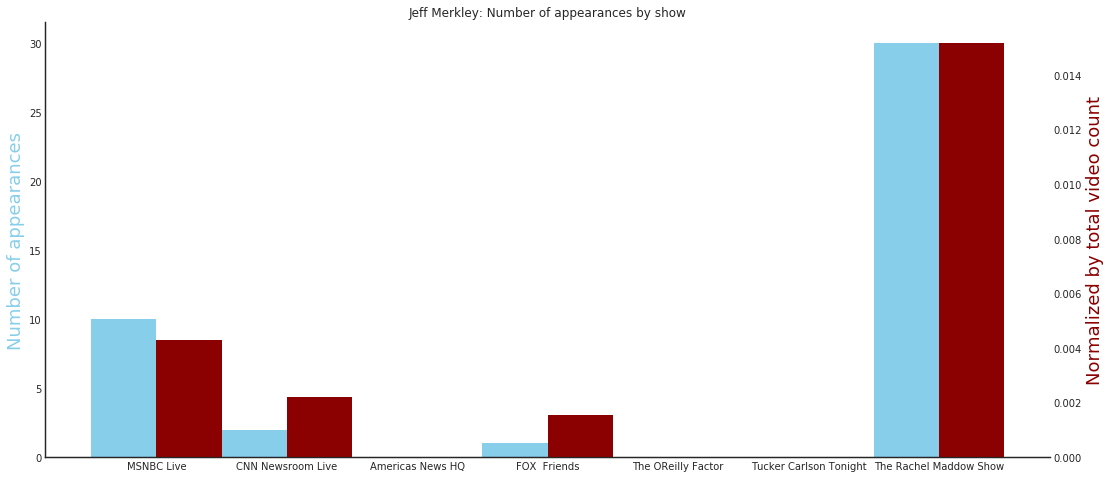

('Jerry', 'Moran') ('U.S. Senate Kansas', 'Republican Party')


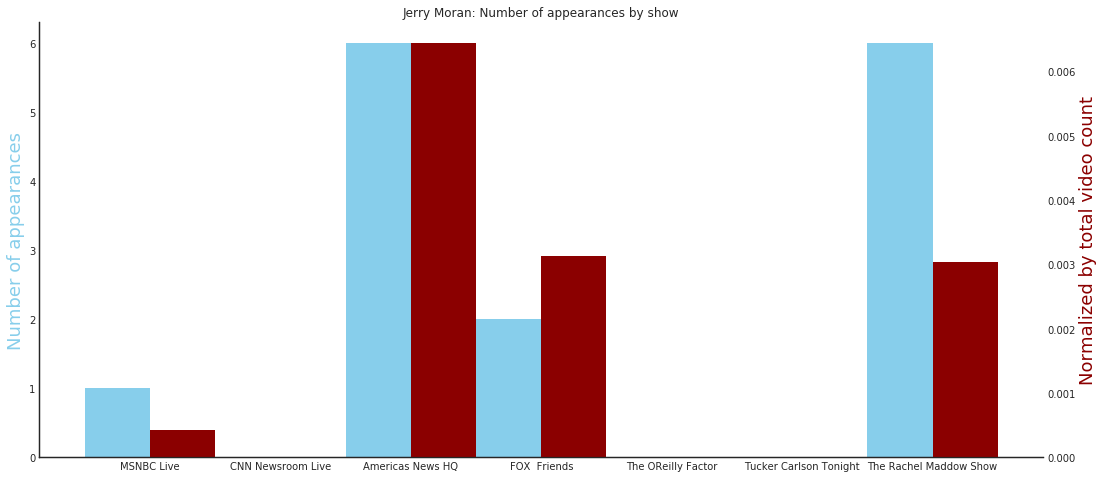

('Jim', 'Inhofe') ('U.S. Senate Oklahoma', 'Republican Party')


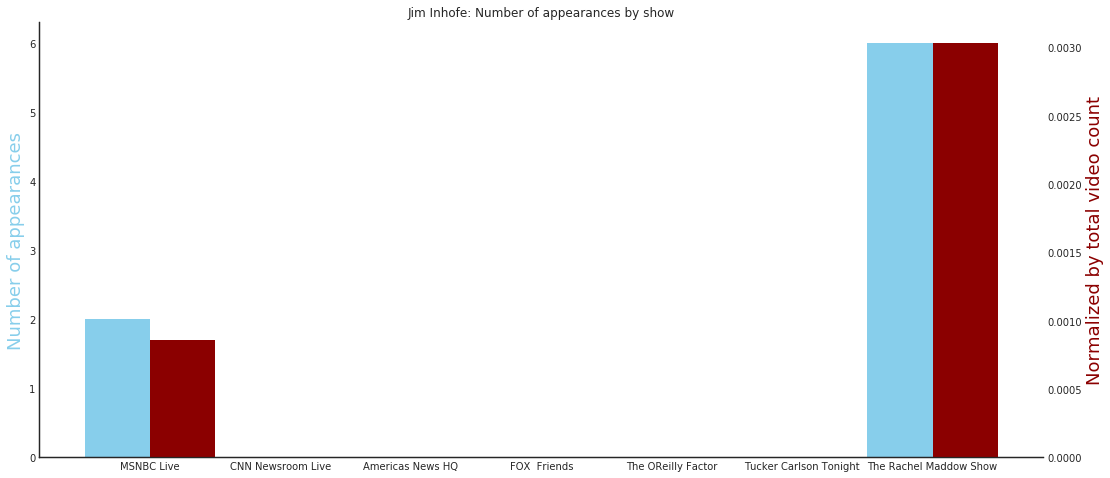

('Jim', 'Risch') ('U.S. Senate Idaho', 'Republican Party')


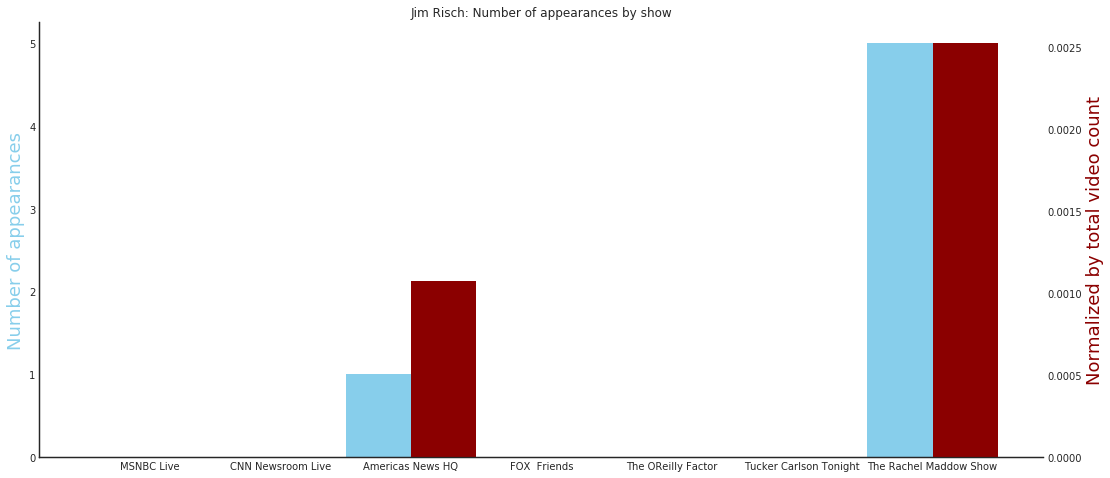

('Joe', 'Donnelly') ('U.S. Senate Indiana', 'Democratic Party')


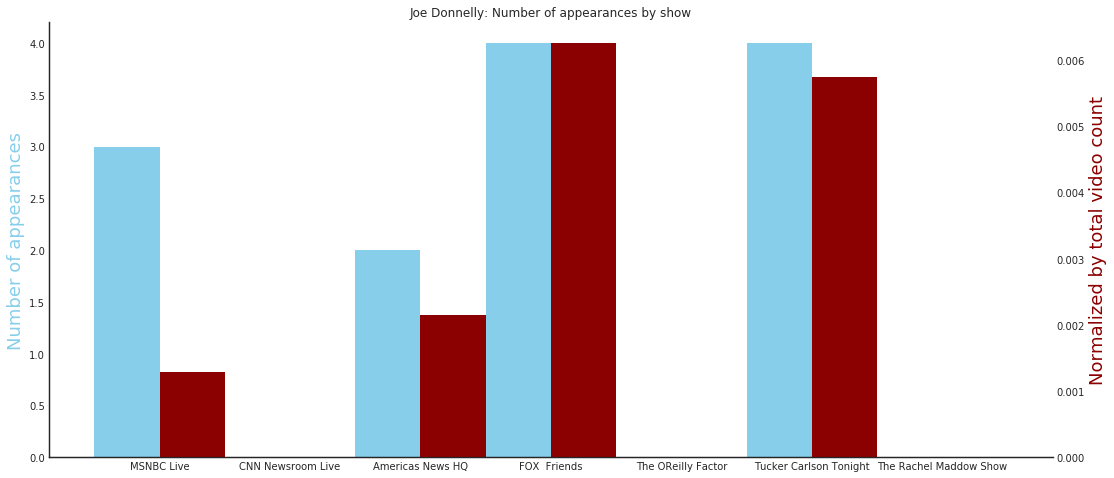

('Joe', 'Manchin') ('U.S. Senate West Virginia', 'Democratic Party')


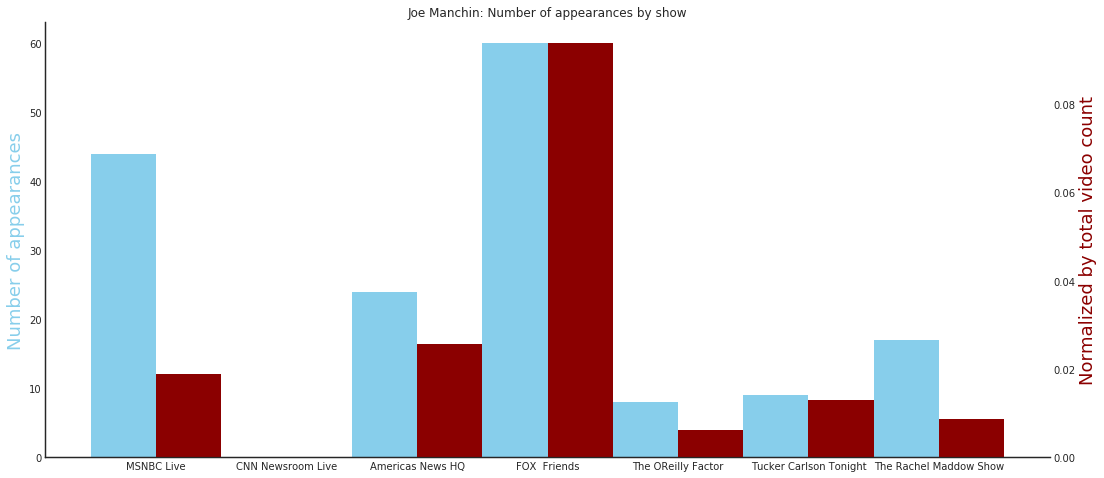

('John', 'Barrasso') ('U.S. Senate Wyoming', 'Republican Party')


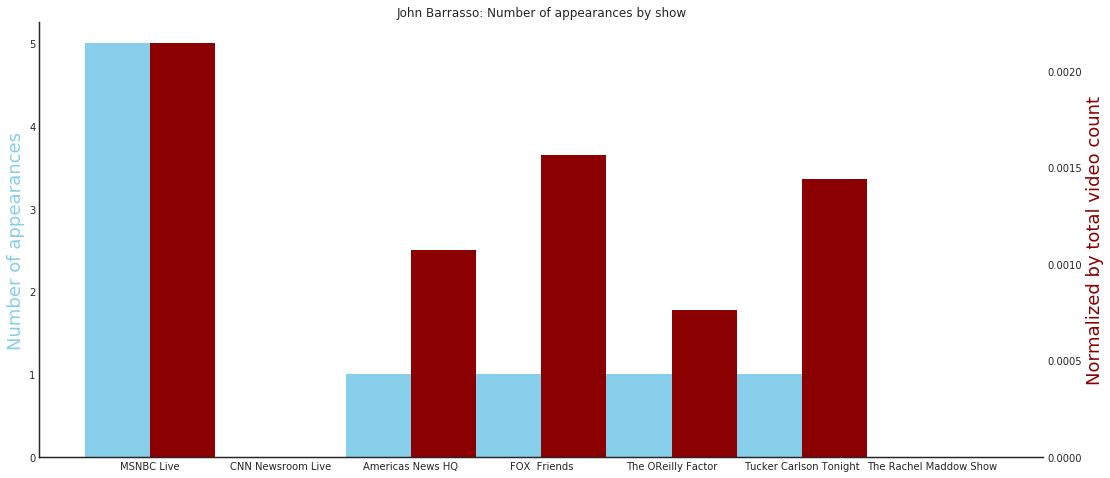

('John', 'Boozman') ('U.S. Senate Arkansas', 'Republican Party')


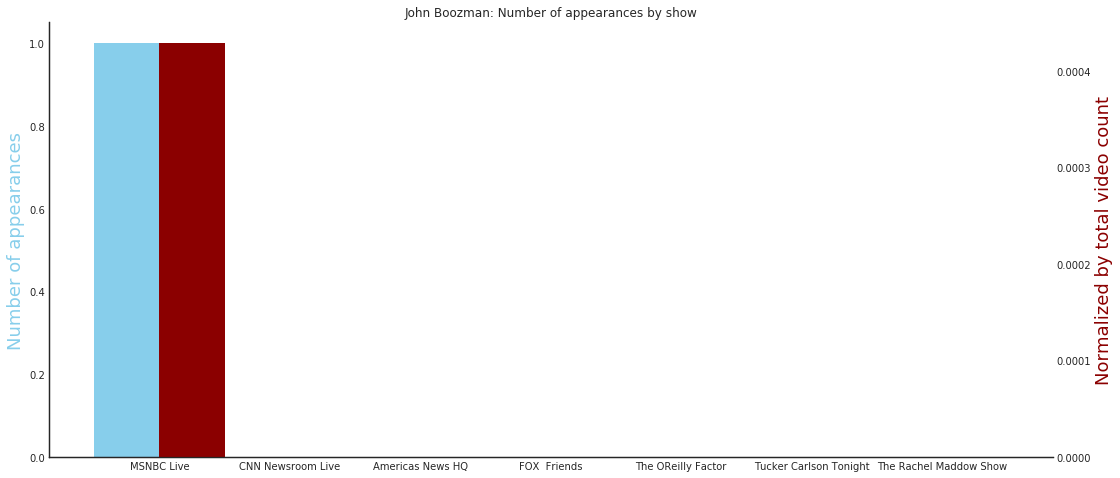

('John', 'Cornyn') ('U.S. Senate Texas', 'Republican Party')


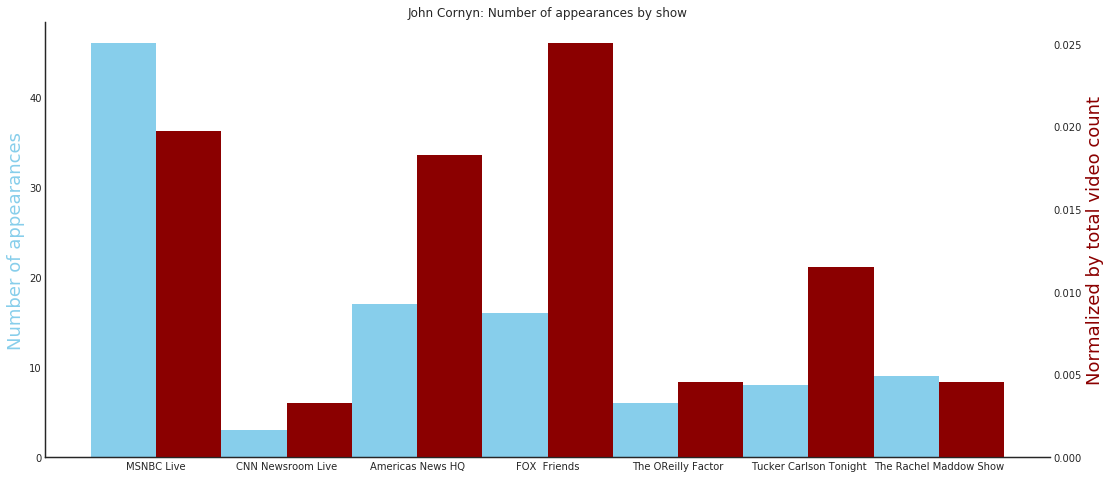

('John', 'Hoeven') ('U.S. Senate North Dakota', 'Republican Party')


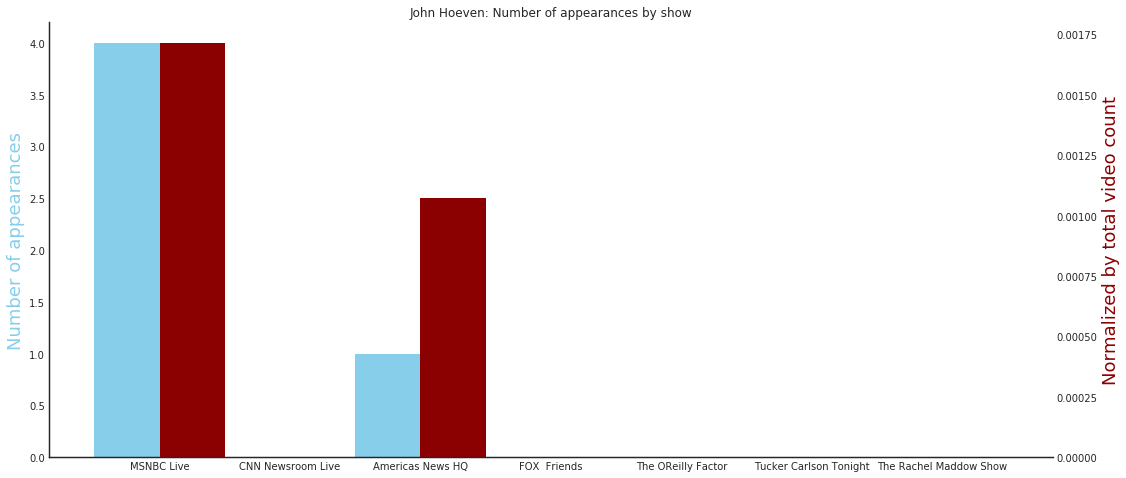

('John', 'Kennedy') ('U.S. Senate Louisiana', 'Republican Party')


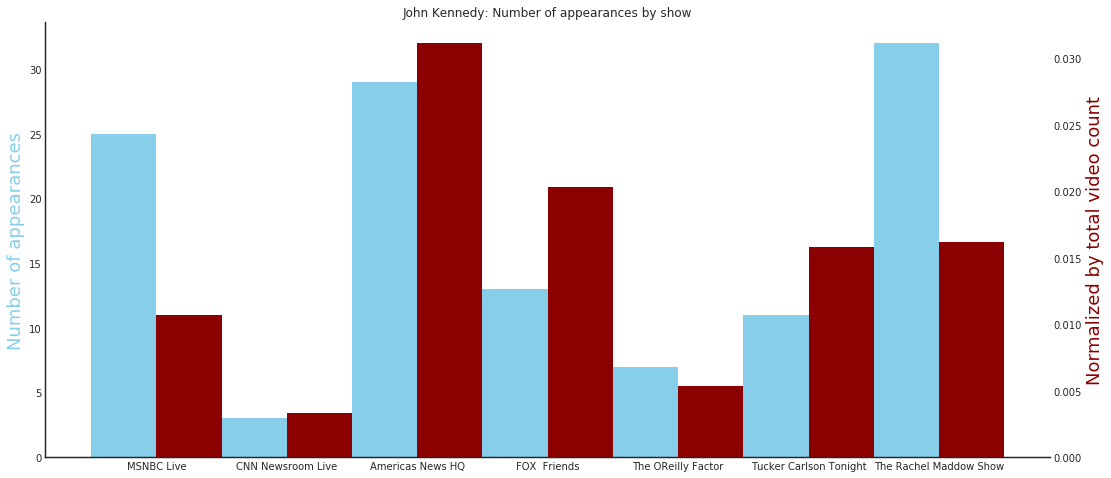

('John', 'McCain') ('U.S. Senate Arizona', 'Republican Party')


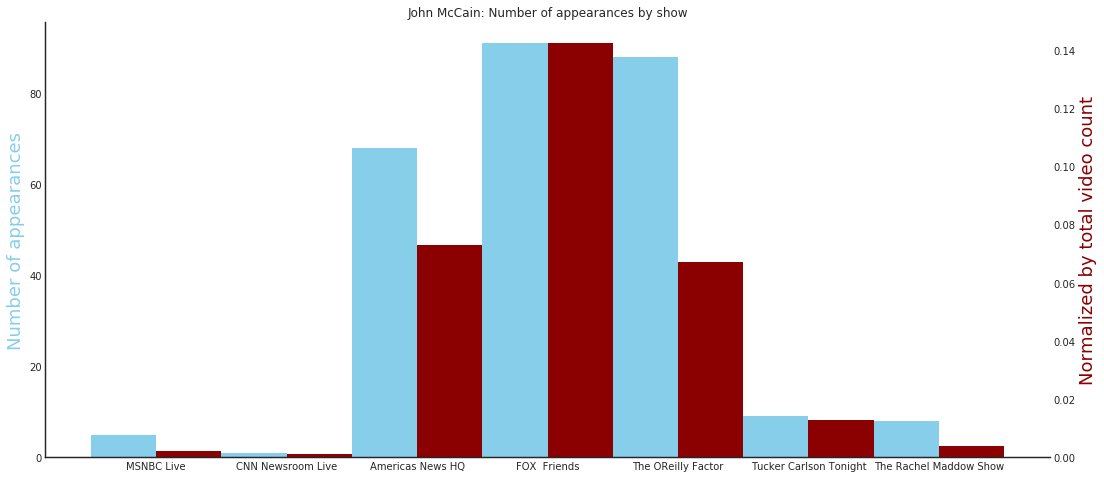

('John', 'Thune') ('U.S. Senate South Dakota', 'Republican Party')


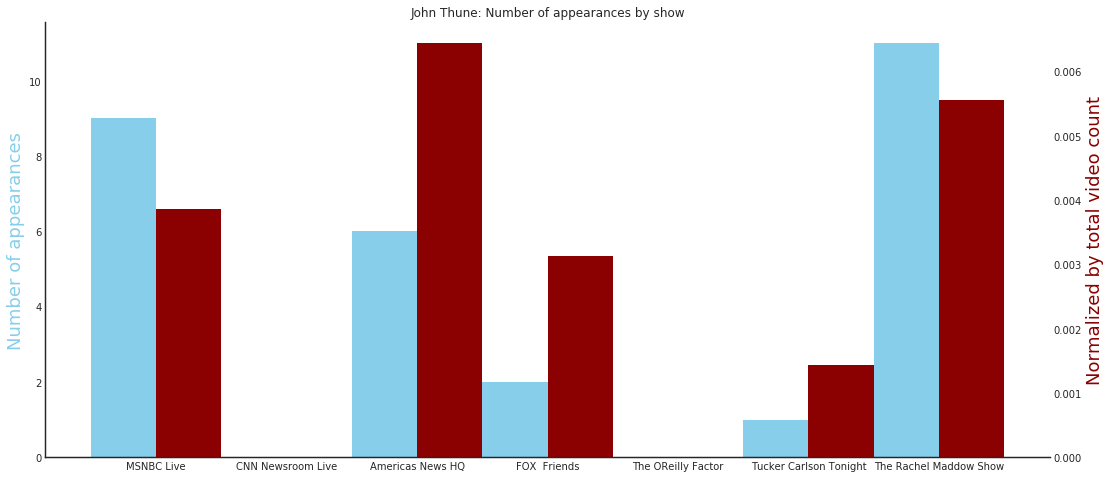

('Johnny', 'Isakson') ('U.S. Senate Georgia', 'Republican Party')


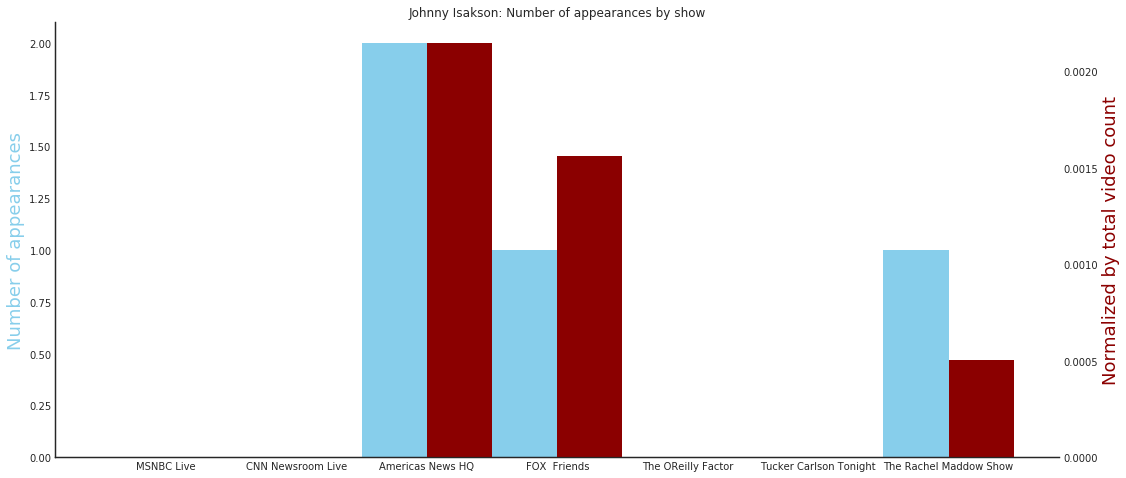

('Jon', 'Tester') ('U.S. Senate Montana', 'Democratic Party')


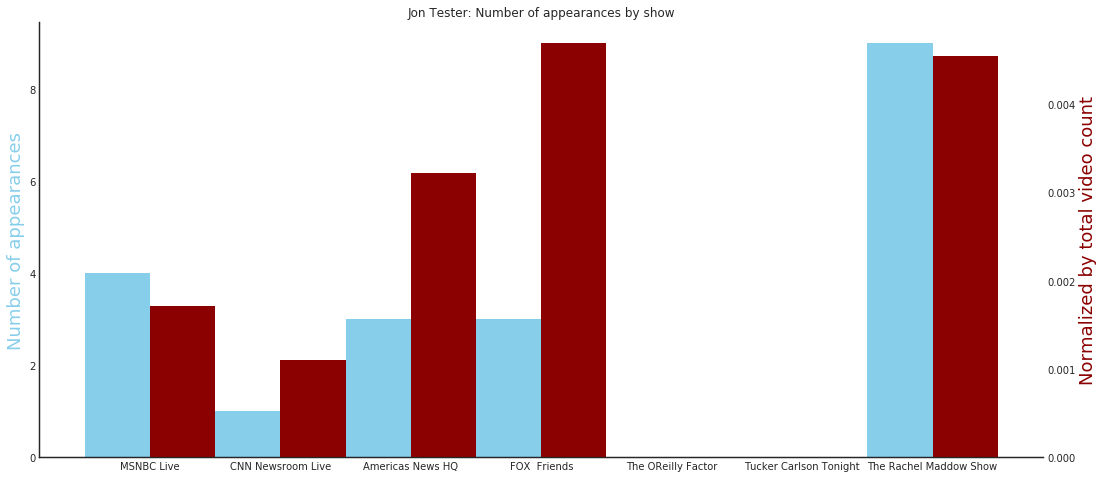

('Joni', 'Ernst') ('U.S. Senate Iowa', 'Republican Party')


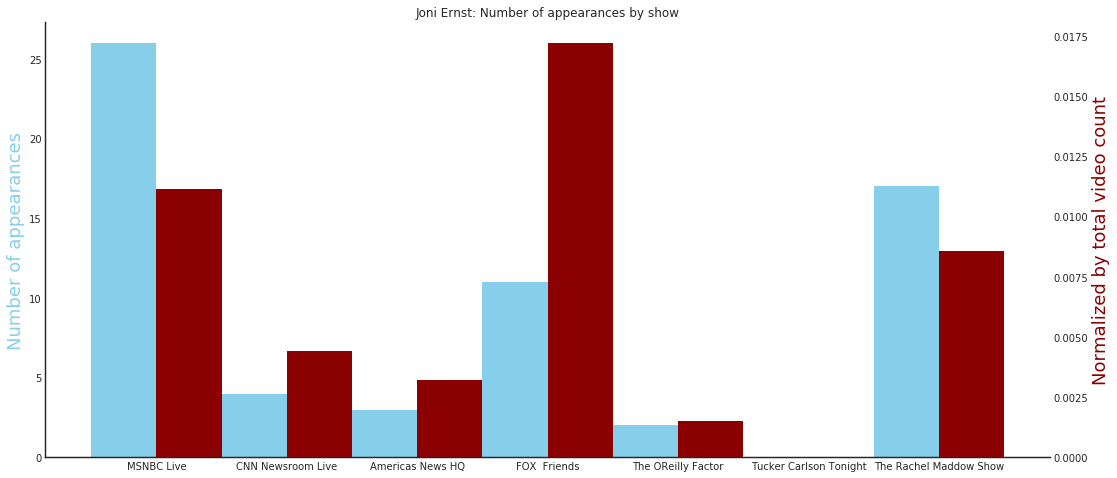

('Kamala', 'Harris') ('U.S. Senate California', 'Democratic Party')


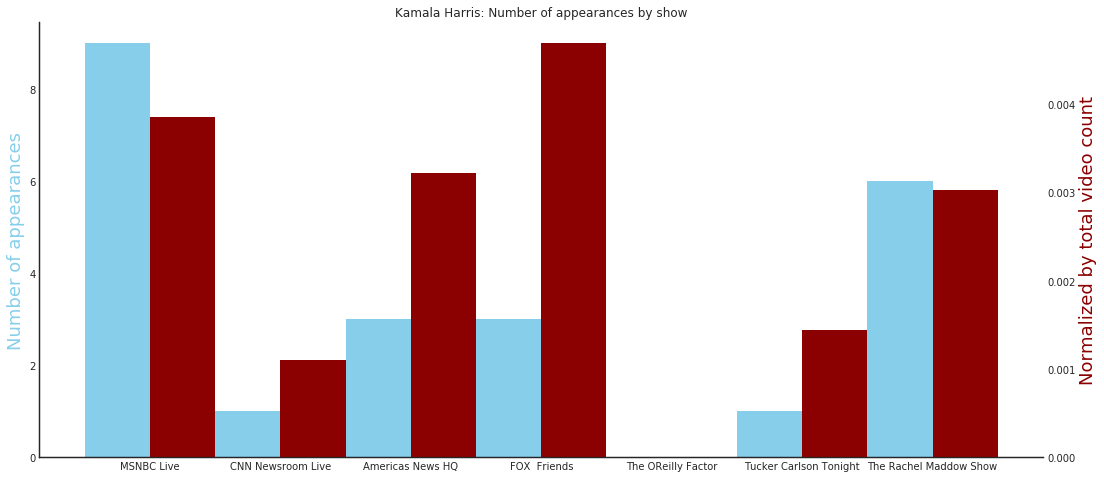

('Kirsten', 'Gillibrand') ('U.S. Senate New York', 'Democratic Party')


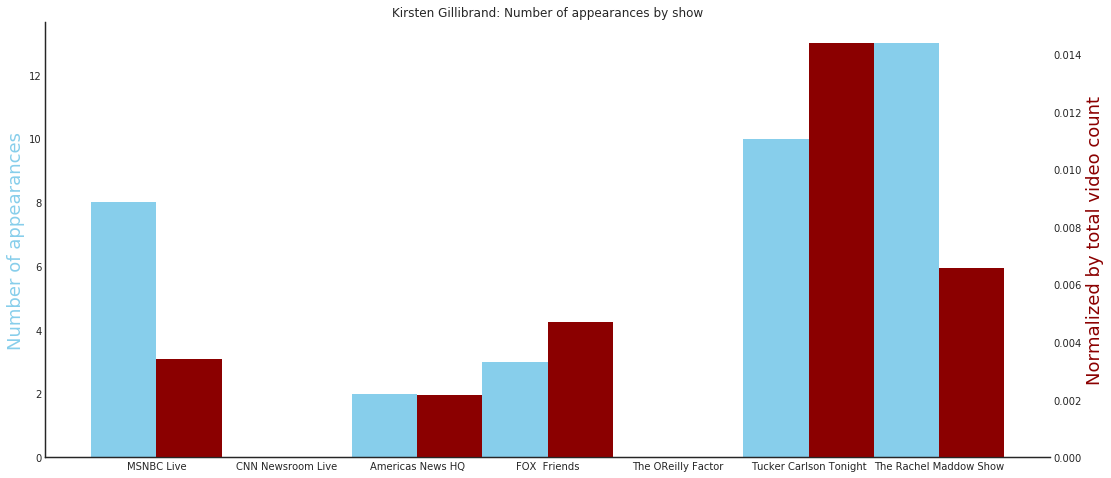

('Lamar', 'Alexander') ('U.S. Senate Tennessee', 'Republican Party')


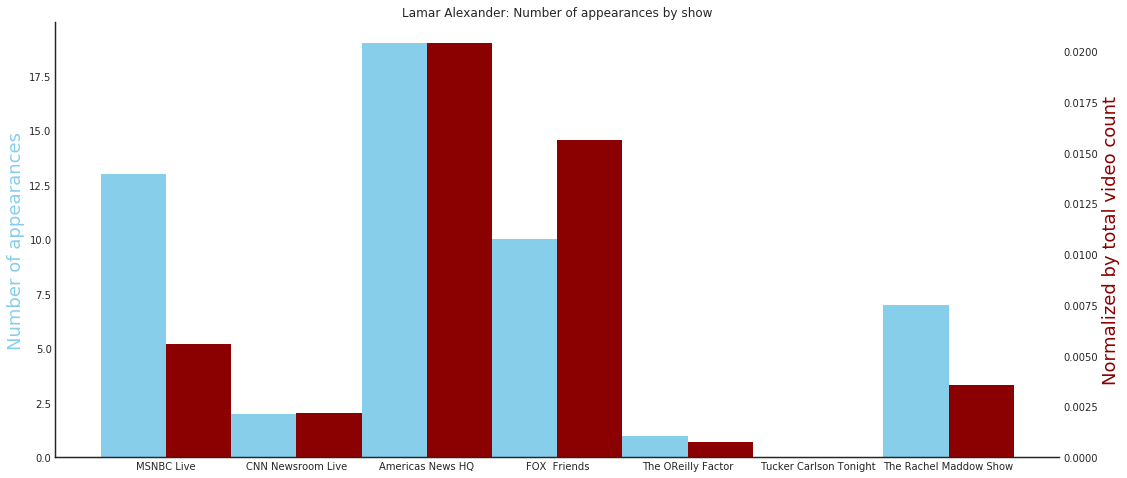

('Lindsey', 'Graham') ('U.S. Senate South Carolina', 'Republican Party')


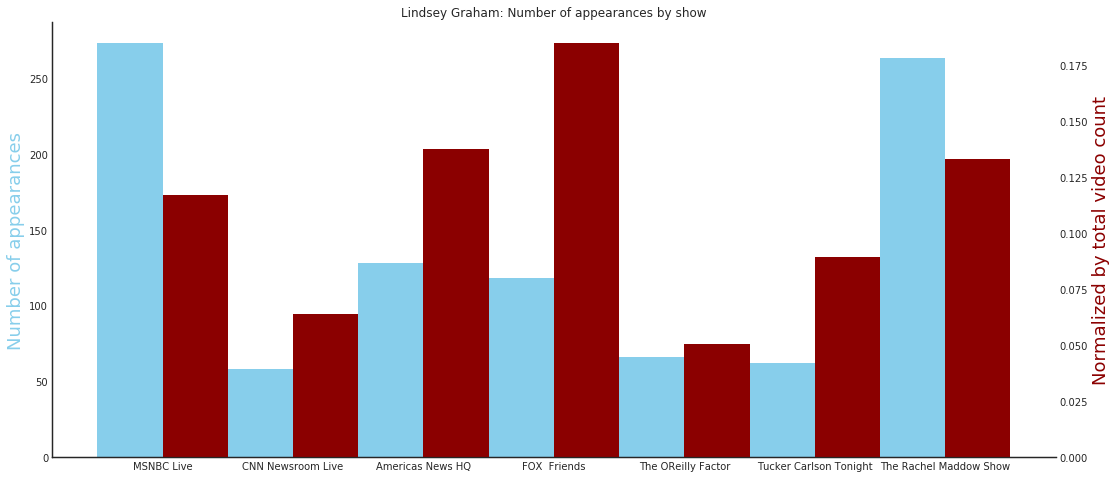

('Lisa', 'Murkowski') ('U.S. Senate Alaska', 'Republican Party')


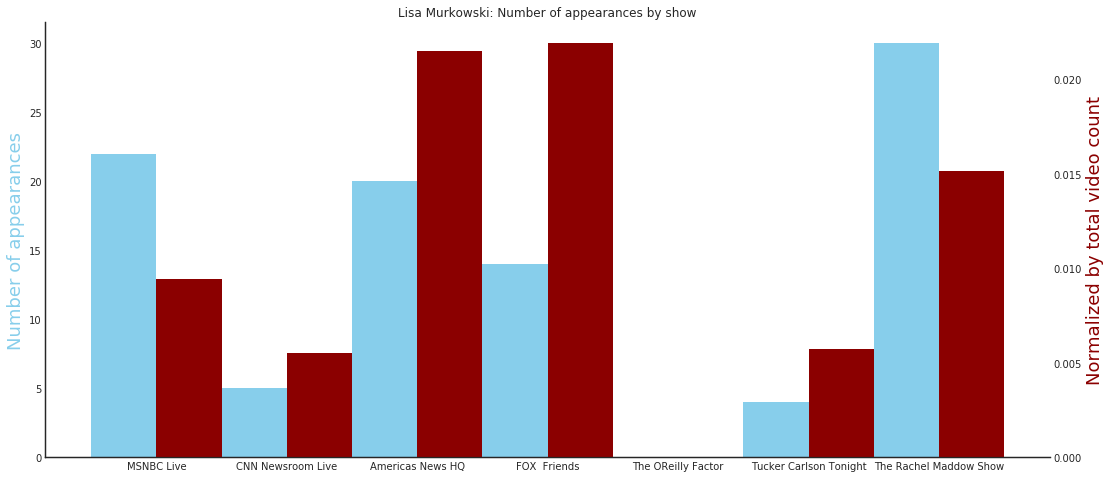

('Maggie', 'Hassan') ('U.S. Senate New Hampshire', 'Democratic Party')


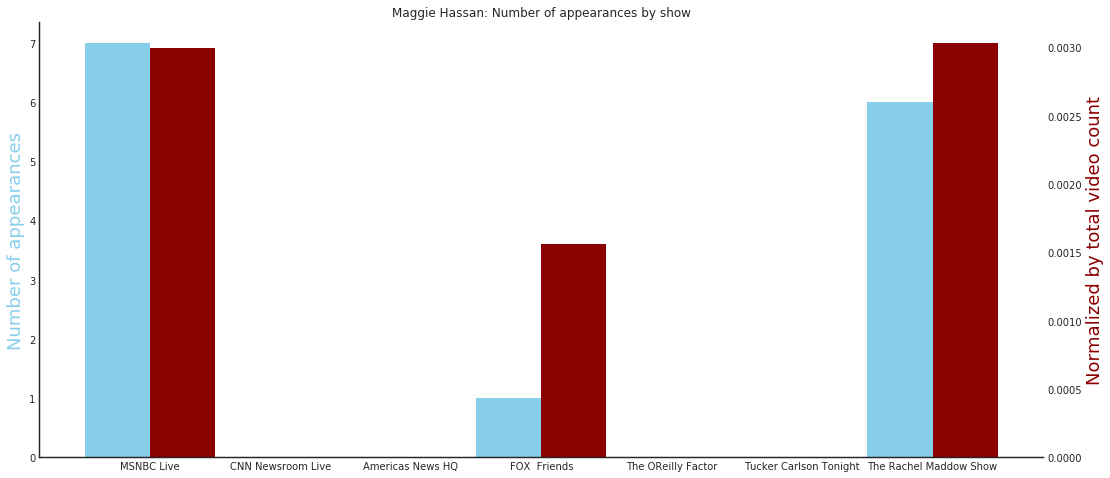

('Marco', 'Rubio') ('U.S. Senate Florida', 'Republican Party')


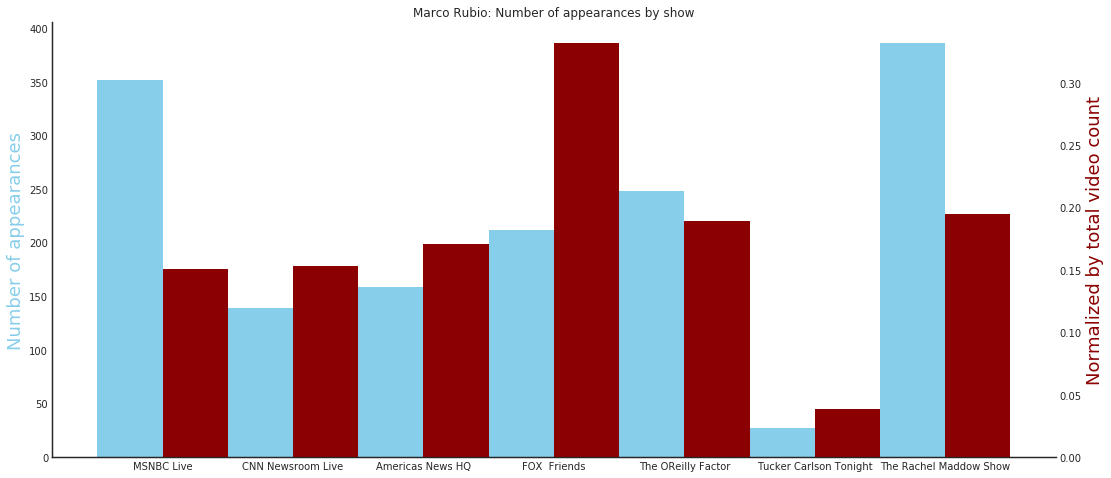

('Maria', 'Cantwell') ('U.S. Senate Washington', 'Democratic Party')


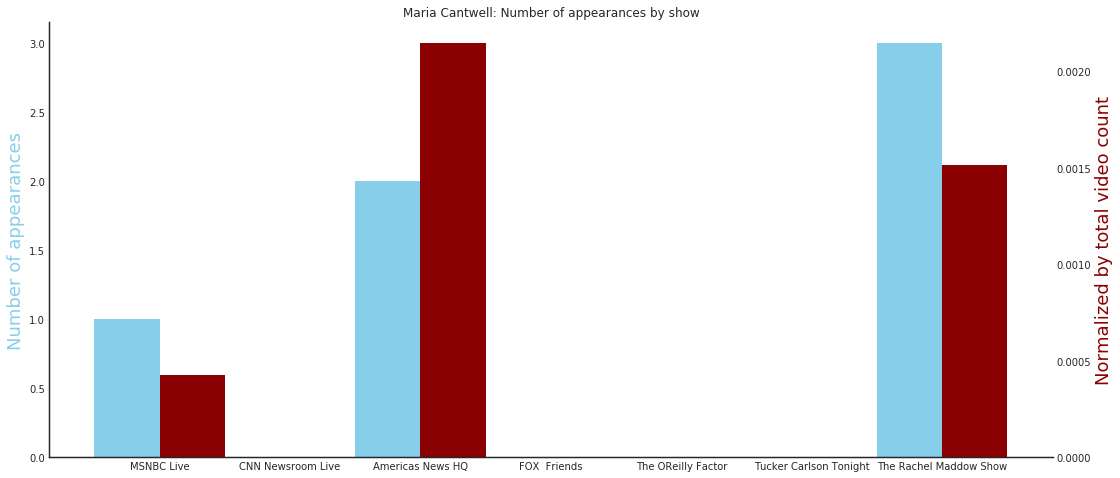

('Mark', 'Warner') ('U.S. Senate Virginia', 'Democratic Party')


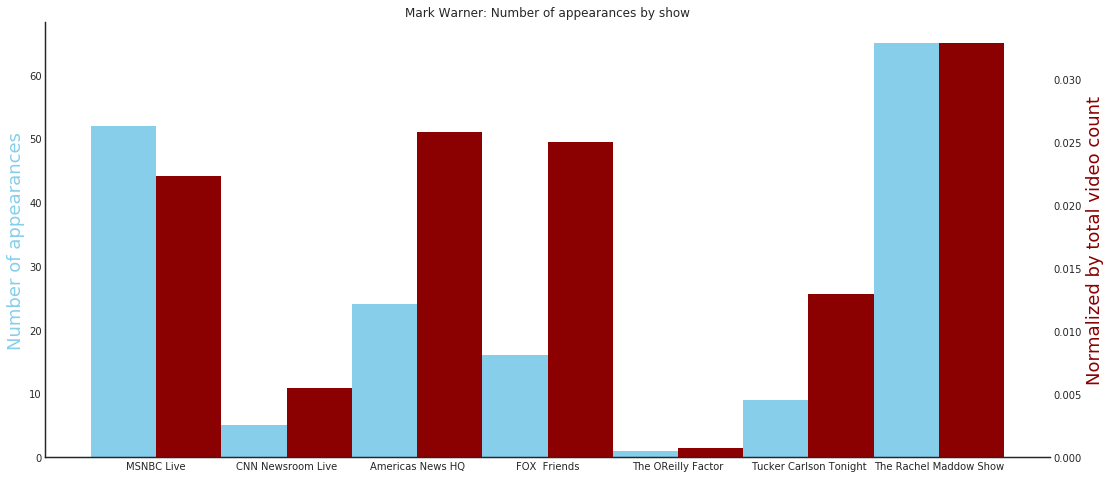

('Martin', 'Heinrich') ('U.S. Senate New Mexico', 'Democratic Party')


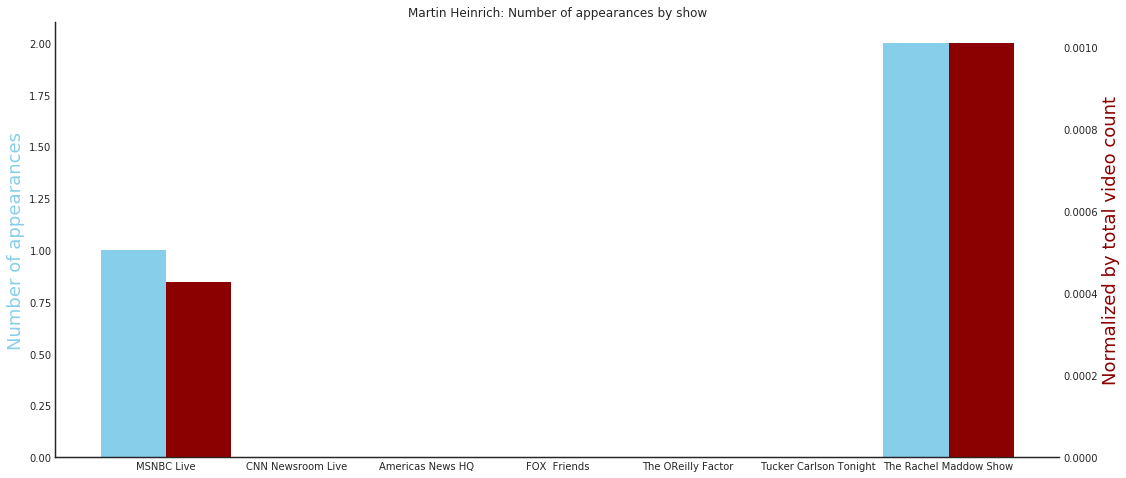

('Mazie', 'Hirono') ('U.S. Senate Hawaii', 'Democratic Party')


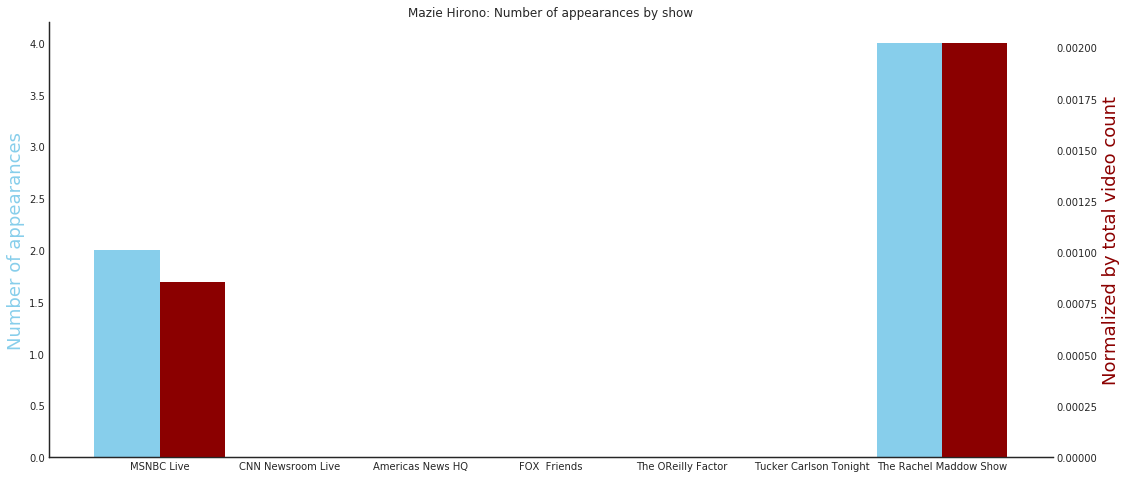

('Michael', 'Bennet') ('U.S. Senate Colorado', 'Democratic Party')


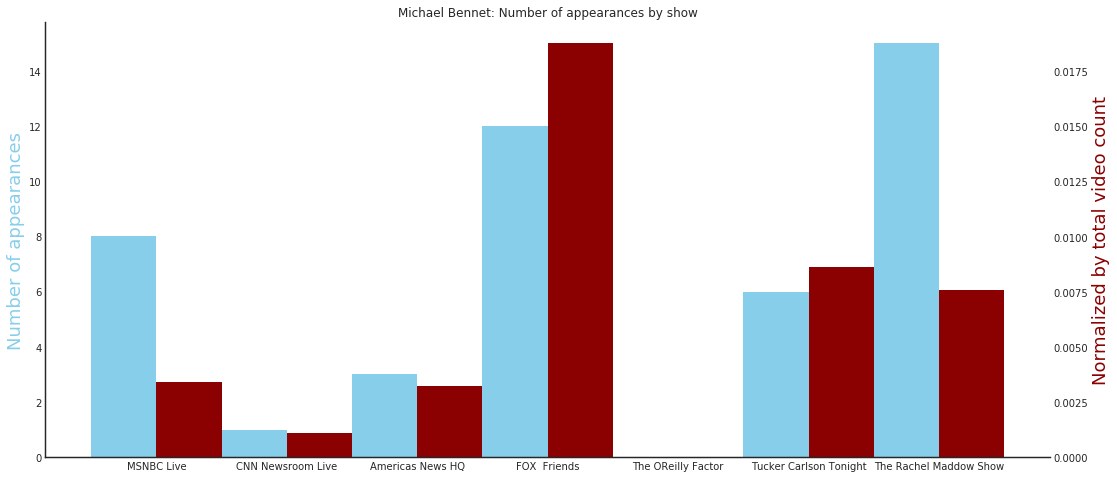

('Mike', 'Crapo') ('U.S. Senate Idaho', 'Republican Party')


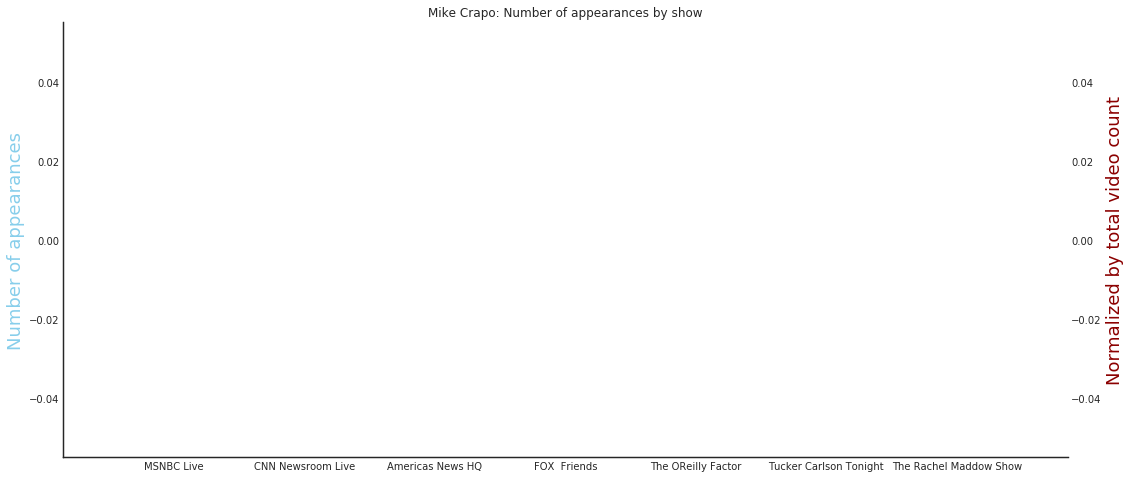

('Mike', 'Enzi') ('U.S. Senate Wyoming', 'Republican Party')


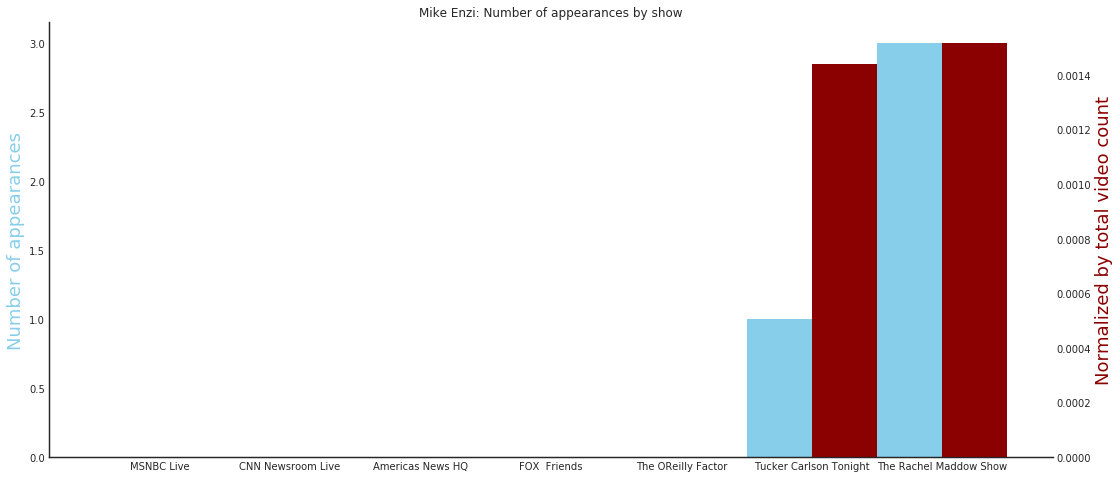

('Mike', 'Lee') ('U.S. Senate Utah', 'Republican Party')


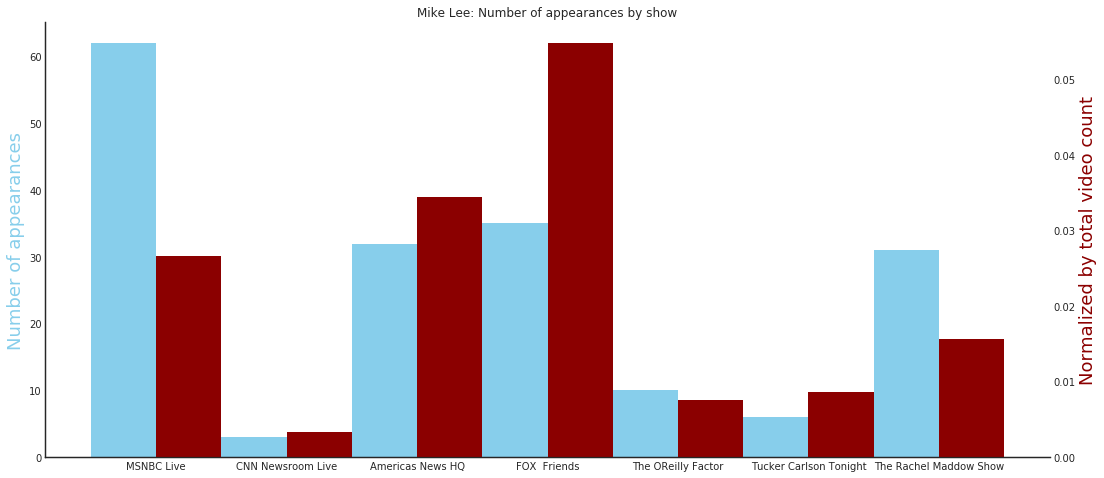

('Mike', 'Rounds') ('U.S. Senate South Dakota', 'Republican Party')


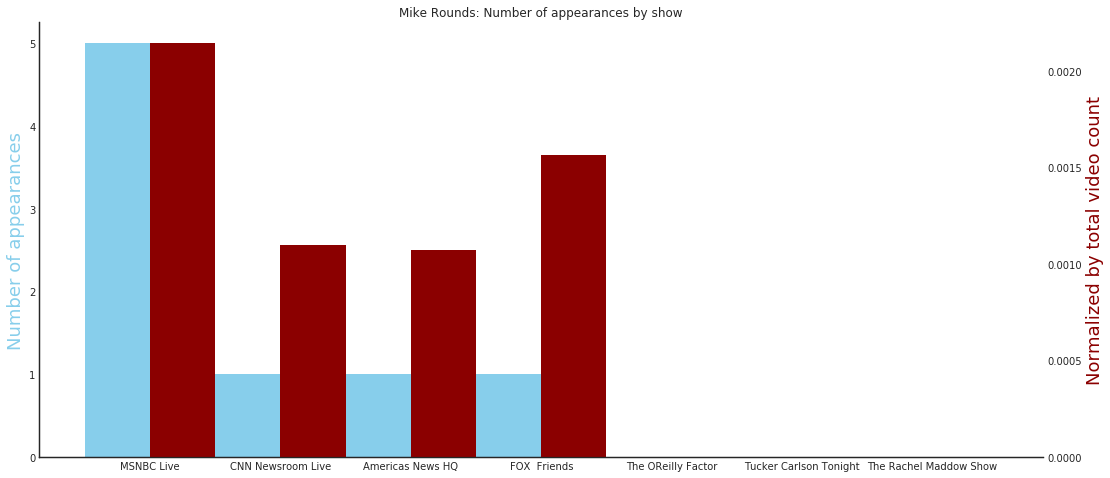

('Mitch', 'McConnell') ('U.S. Senate Kentucky', 'Republican Party')


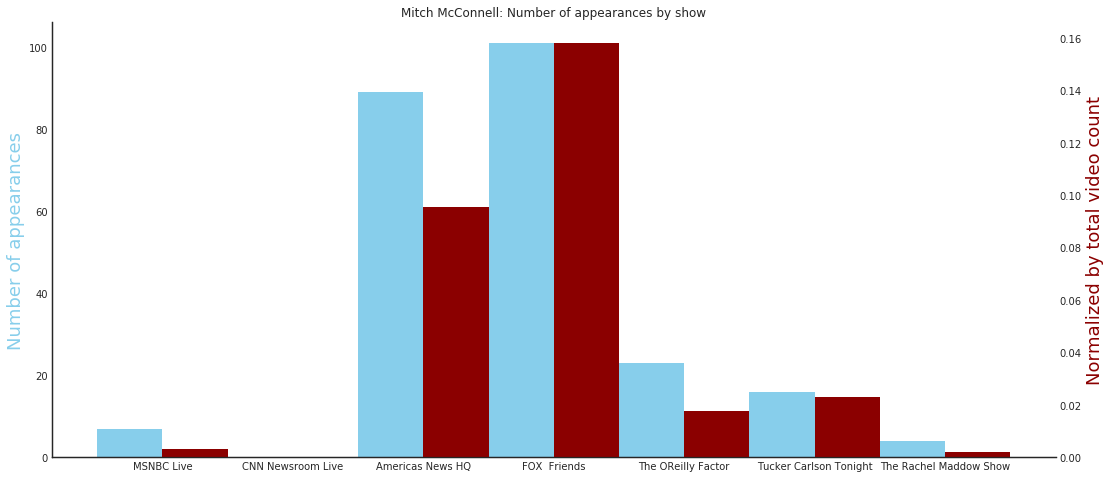

('Orrin', 'Hatch') ('U.S. Senate Utah', 'Republican Party')


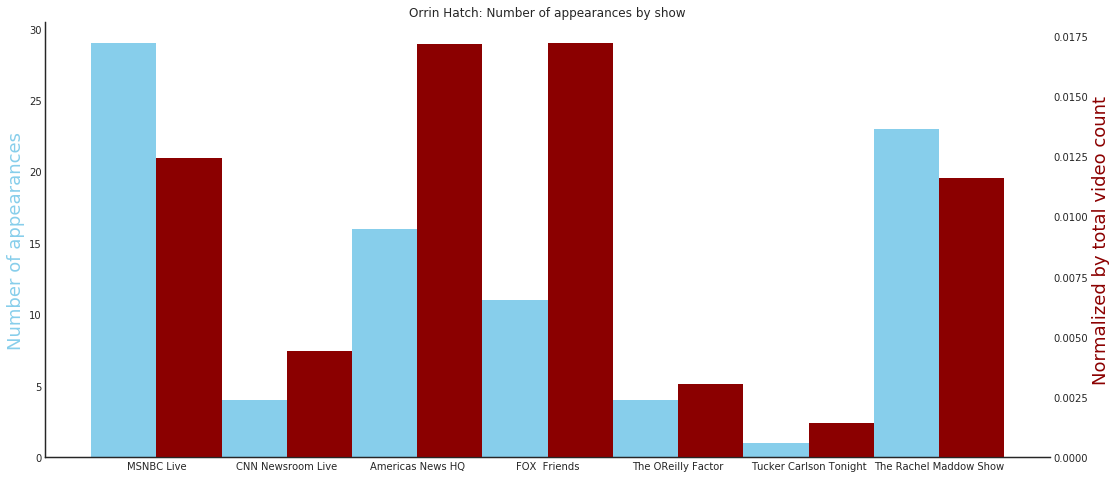

('Pat', 'Roberts') ('U.S. Senate Kansas', 'Republican Party')


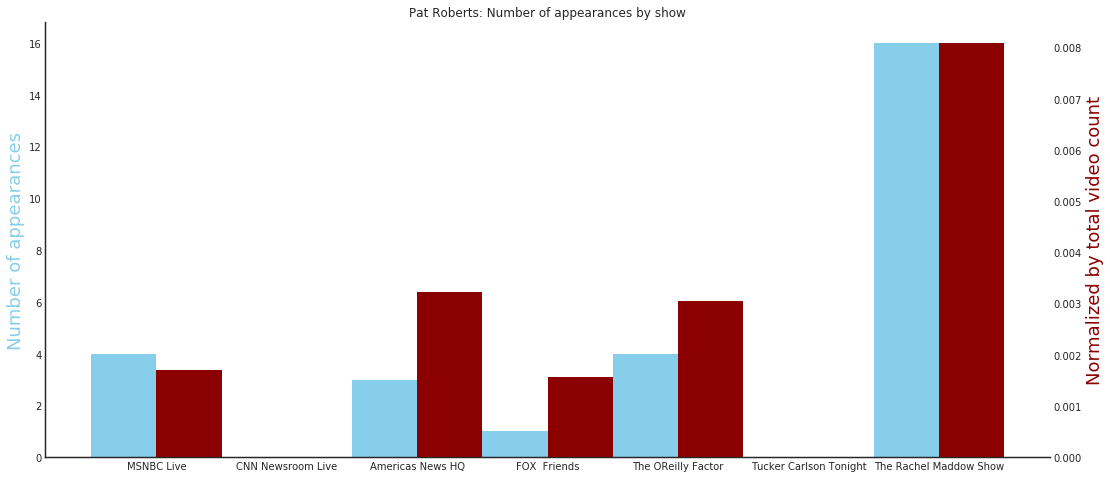

('Pat', 'Toomey') ('U.S. Senate Pennsylvania', 'Republican Party')


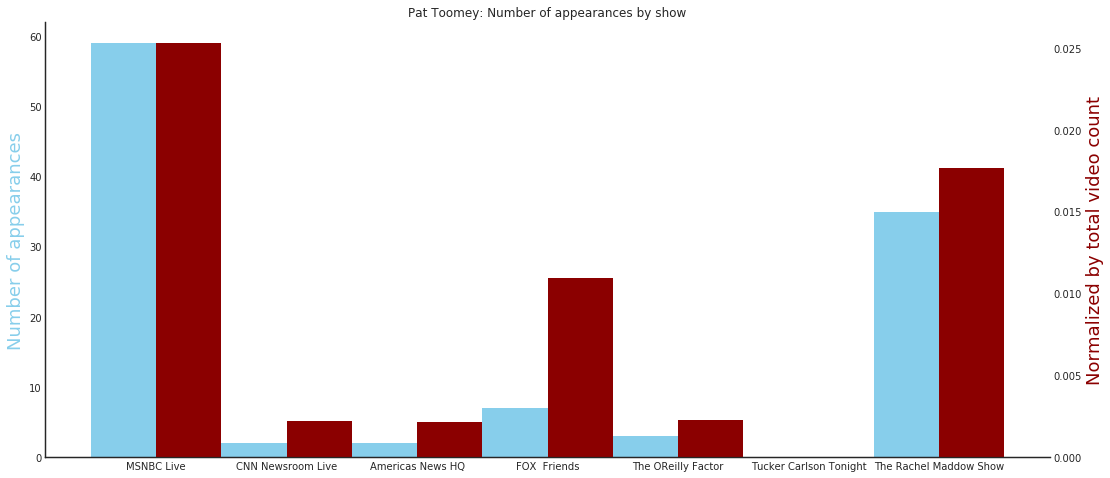

('Patrick', 'Leahy') ('U.S. Senate Vermont', 'Democratic Party')


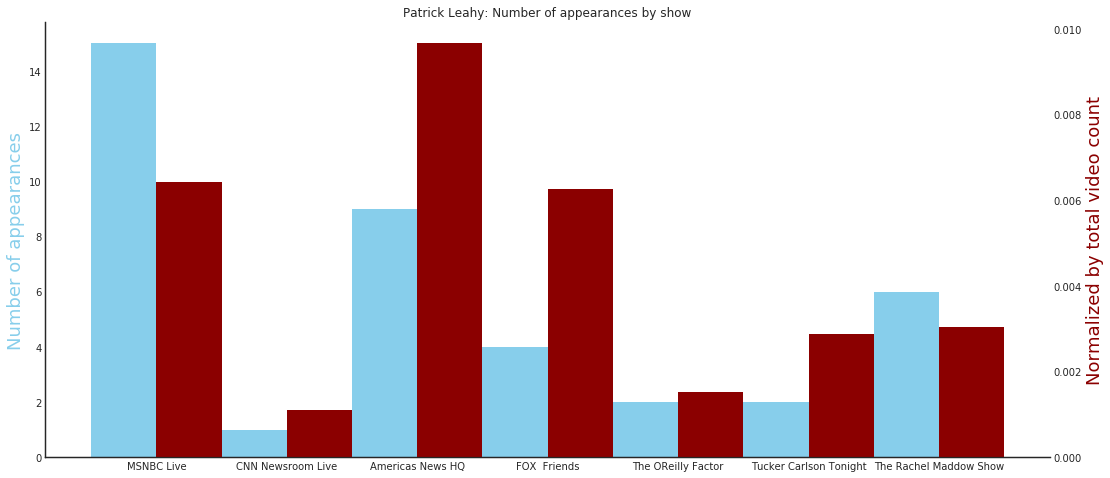

('Patty', 'Murray') ('U.S. Senate Washington', 'Democratic Party')


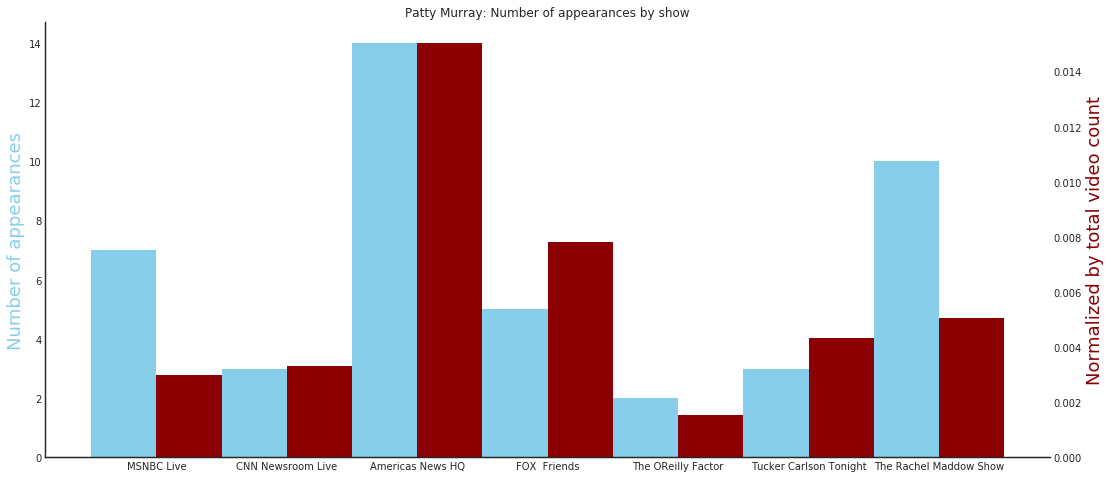

('Rand', 'Paul') ('U.S. Senate Kentucky', 'Republican Party')


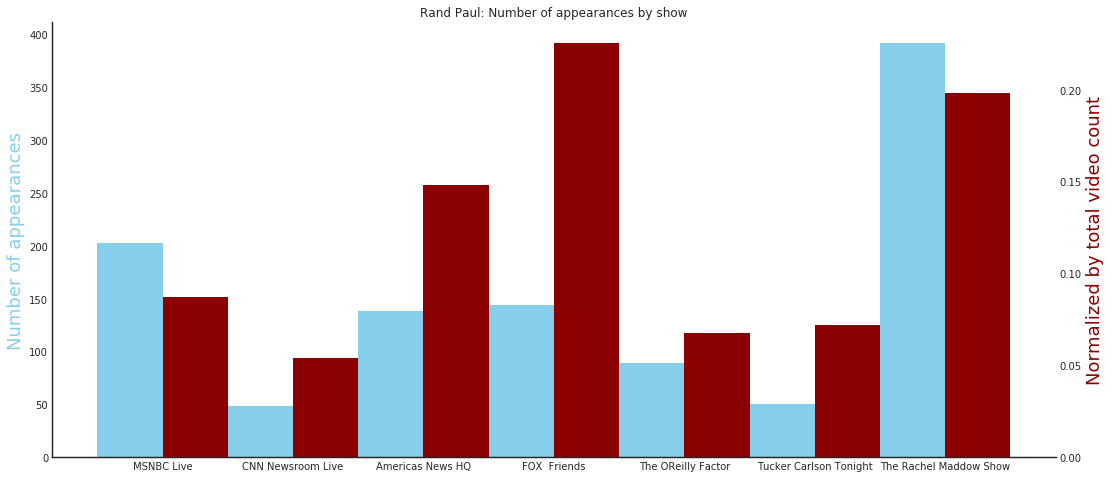

('Richard', 'Blumenthal') ('U.S. Senate Connecticut', 'Democratic Party')


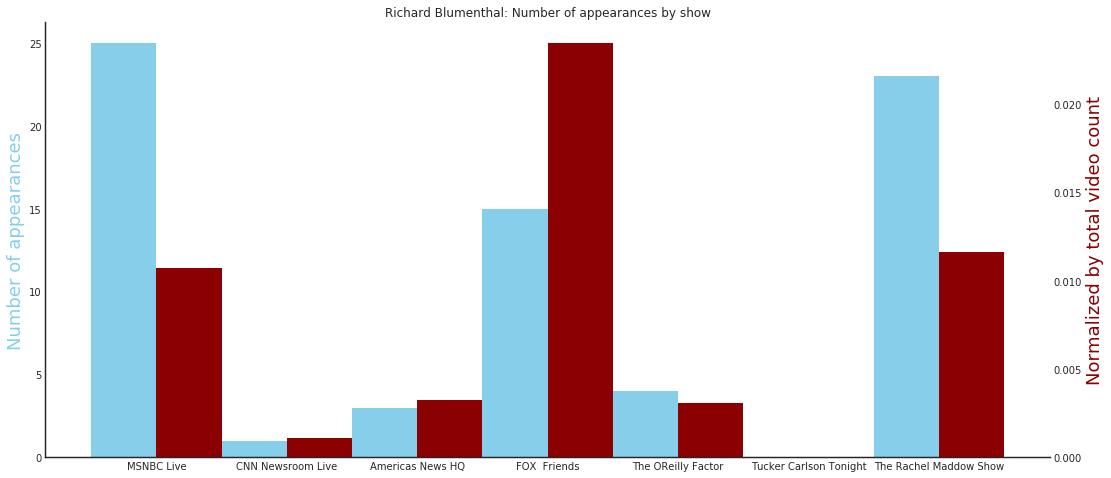

('Richard', 'Burr') ('U.S. Senate North Carolina', 'Republican Party')


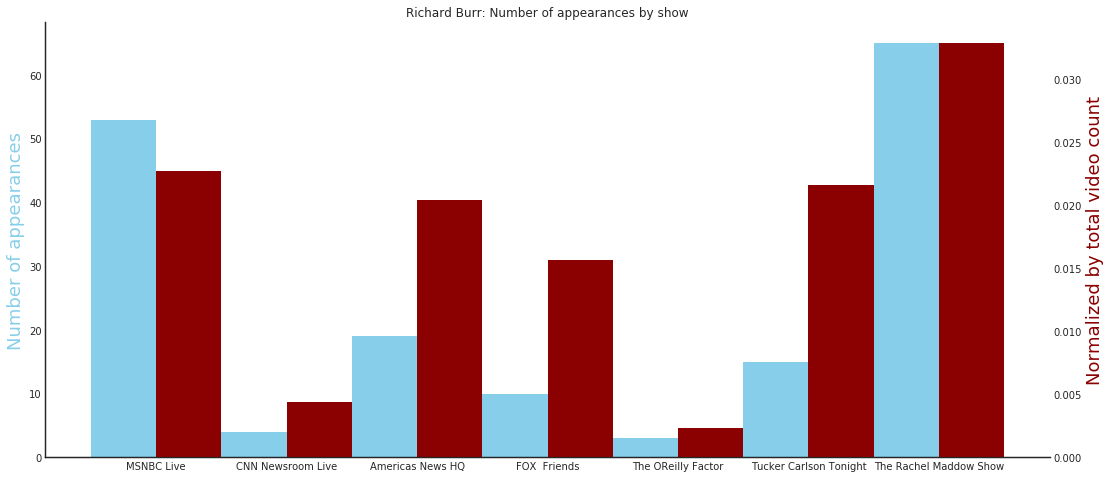

('Richard', 'Shelby') ('U.S. Senate Alabama', 'Republican Party')


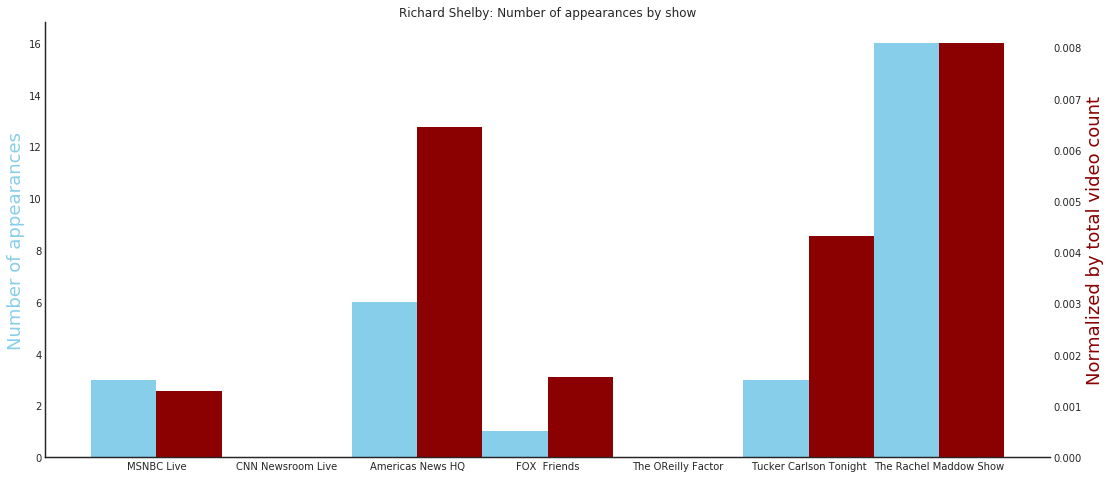

('Rob', 'Portman') ('U.S. Senate Ohio', 'Republican Party')


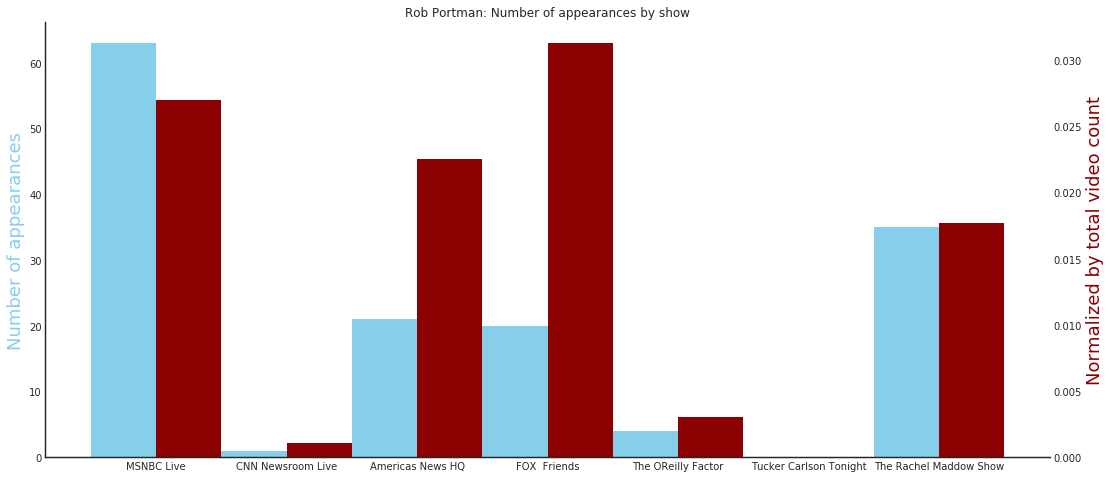

('Roger', 'Wicker') ('U.S. Senate Mississippi', 'Republican Party')


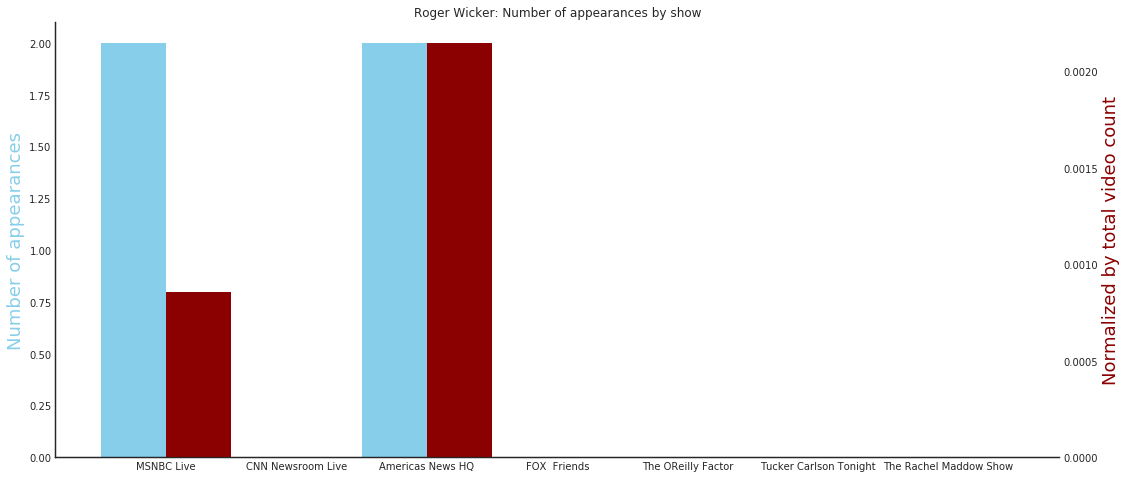

('Ron', 'Johnson') ('U.S. Senate Wisconsin', 'Republican Party')


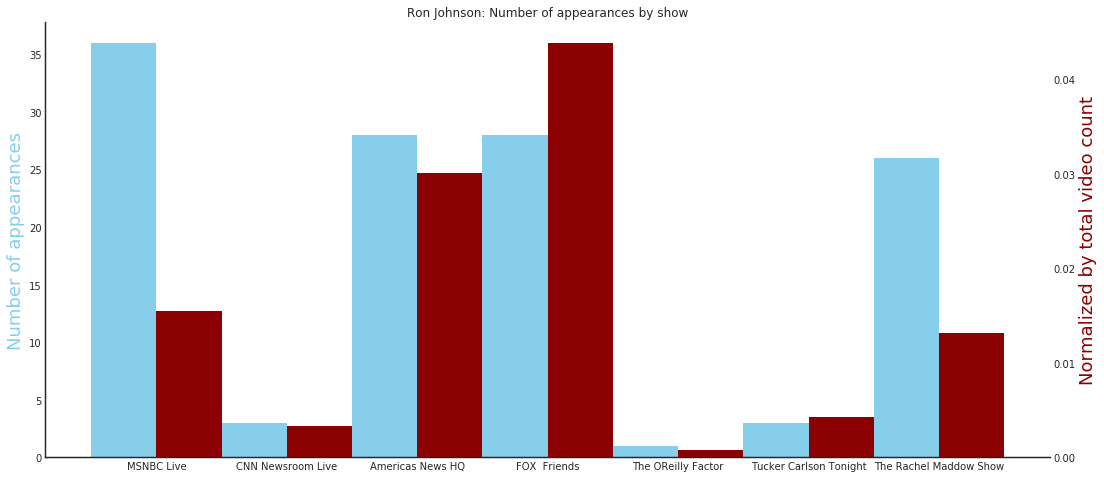

('Ron', 'Wyden') ('U.S. Senate Oregon', 'Democratic Party')


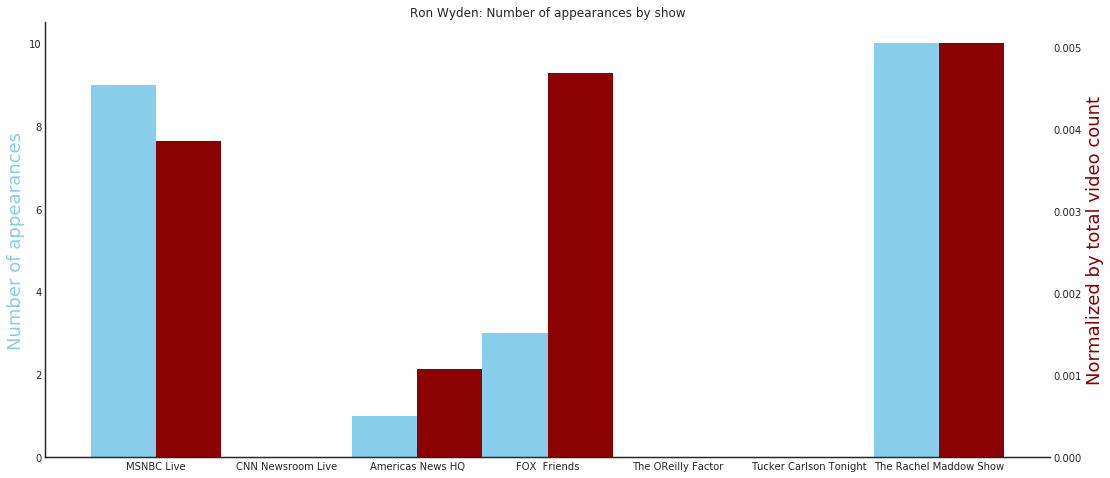

('Roy', 'Blunt') ('U.S. Senate Missouri', 'Republican Party')


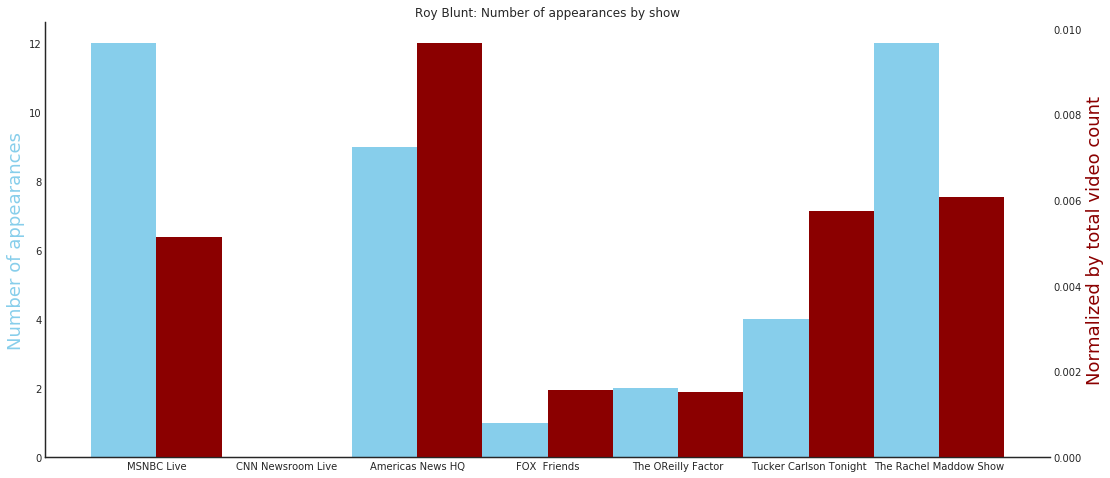

('Sheldon', 'Whitehouse') ('U.S. Senate Rhode Island', 'Democratic Party')


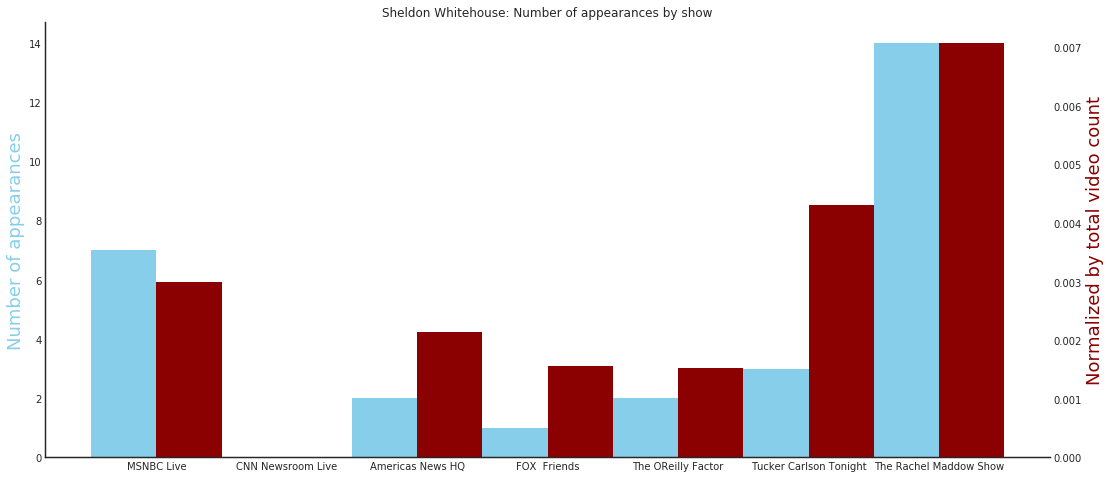

('Shelley', 'Capito') ('U.S. Senate West Virginia', 'Republican Party')


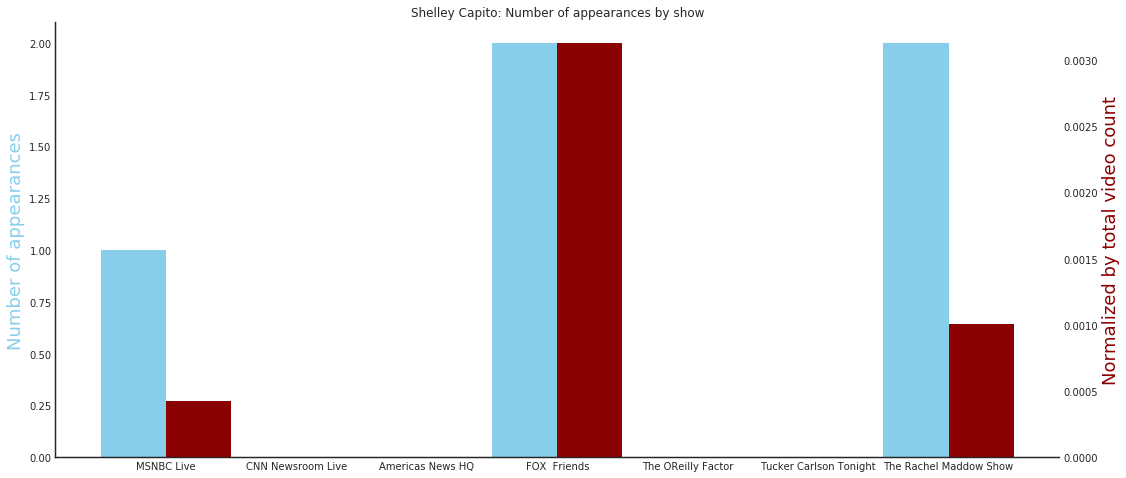

('Sherrod', 'Brown') ('U.S. Senate Ohio', 'Democratic Party')


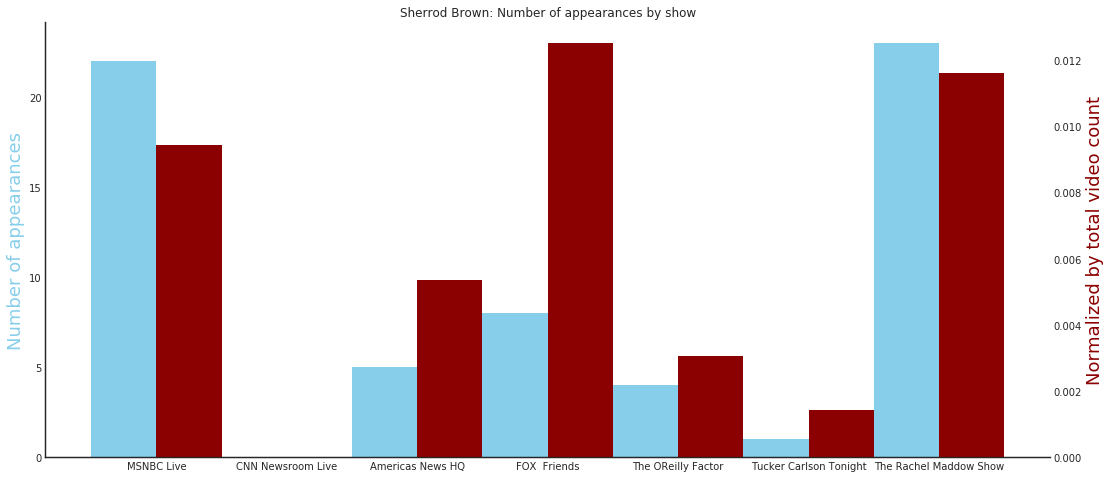

('Steve', 'Daines') ('U.S. Senate Montana', 'Republican Party')


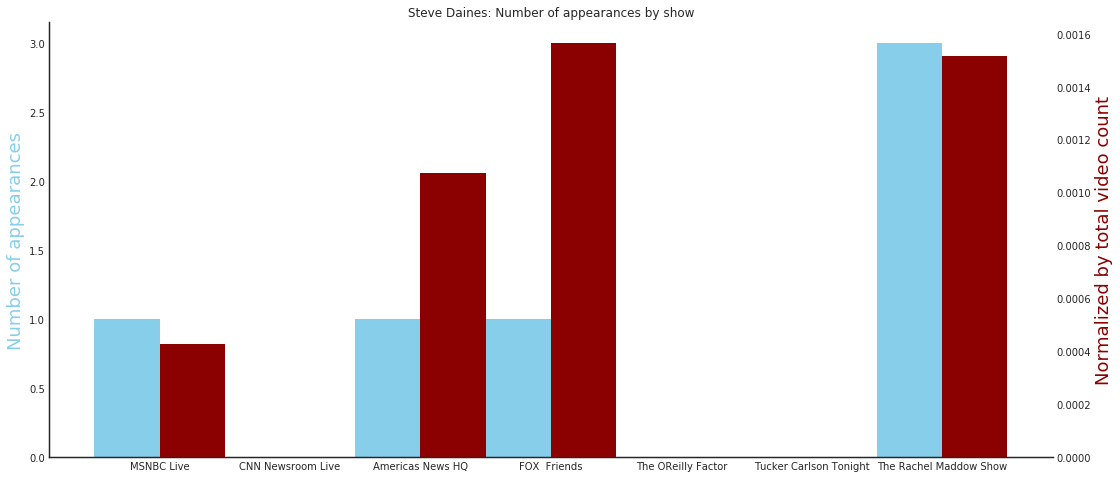

('Susan', 'Collins') ('U.S. Senate Maine', 'Republican Party')


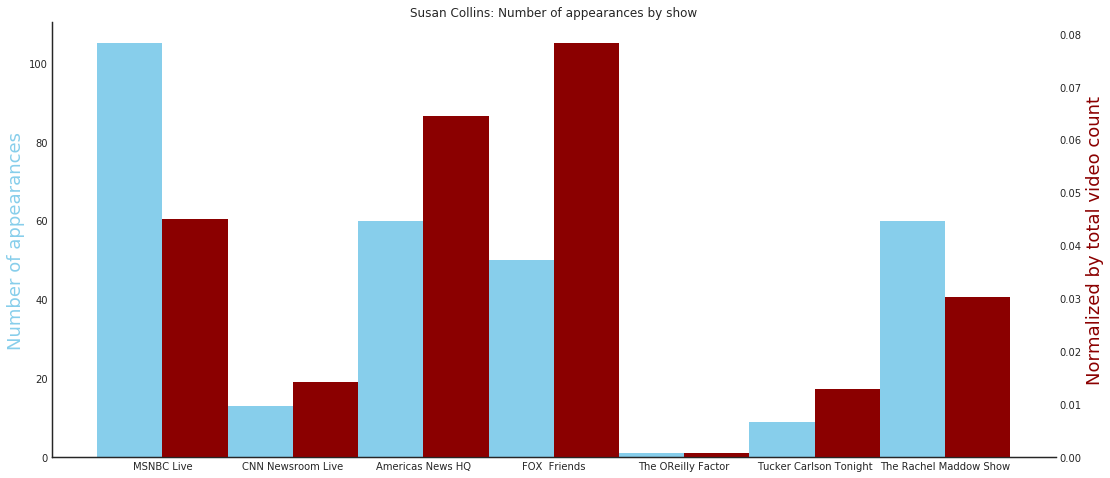

('Tammy', 'Baldwin') ('U.S. Senate Wisconsin', 'Democratic Party')


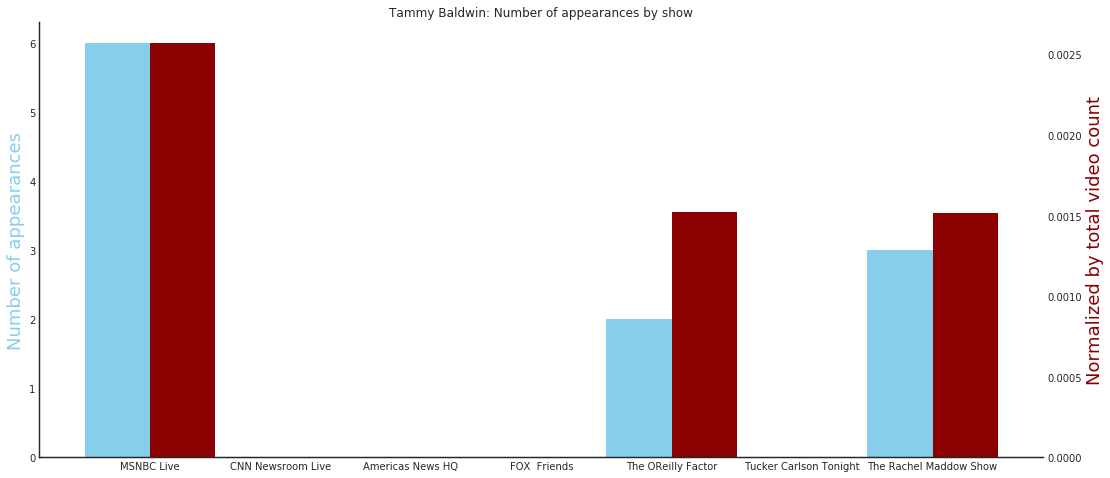

('Tammy', 'Duckworth') ('U.S. Senate Illinois', 'Democratic Party')


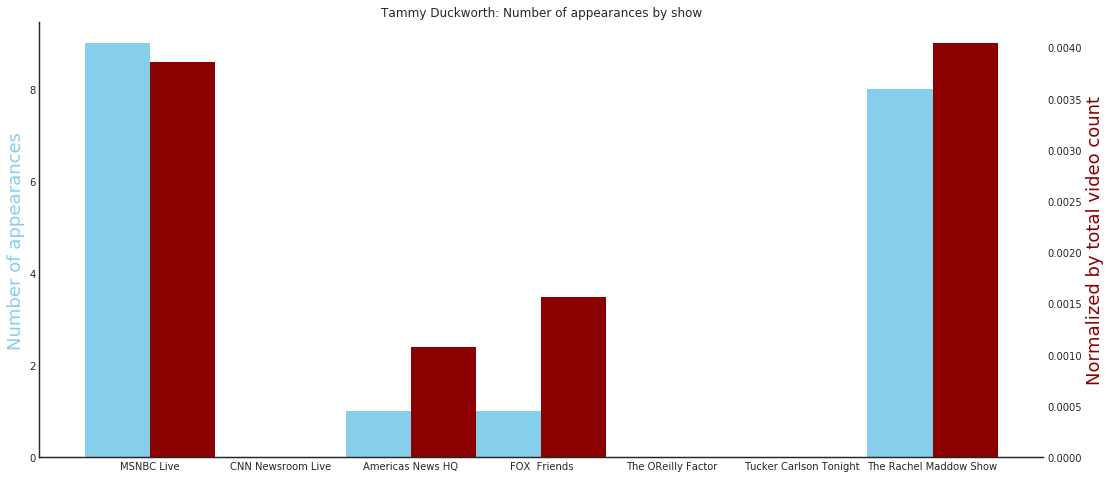

('Ted', 'Cruz') ('U.S. Senate Texas', 'Republican Party')


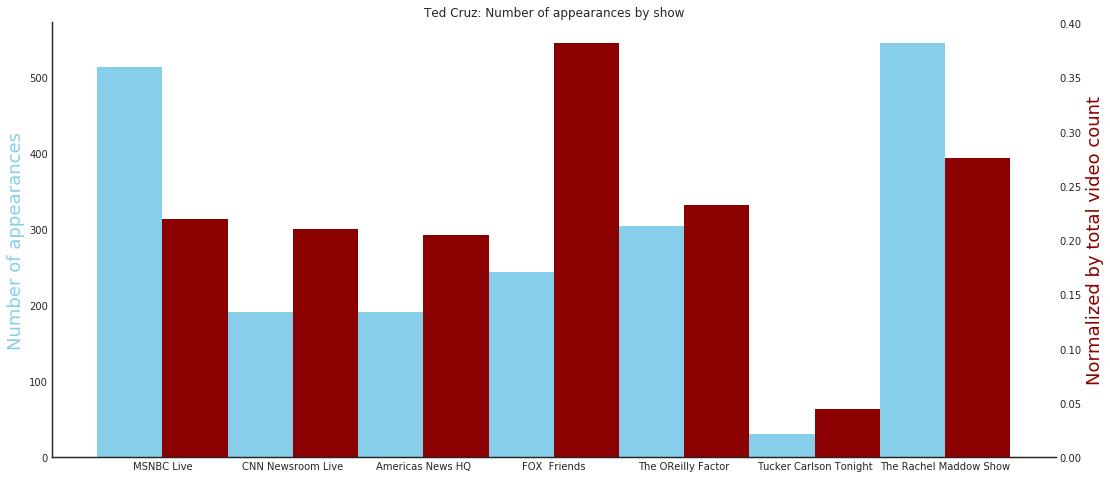

('Thom', 'Tillis') ('U.S. Senate North Carolina', 'Republican Party')


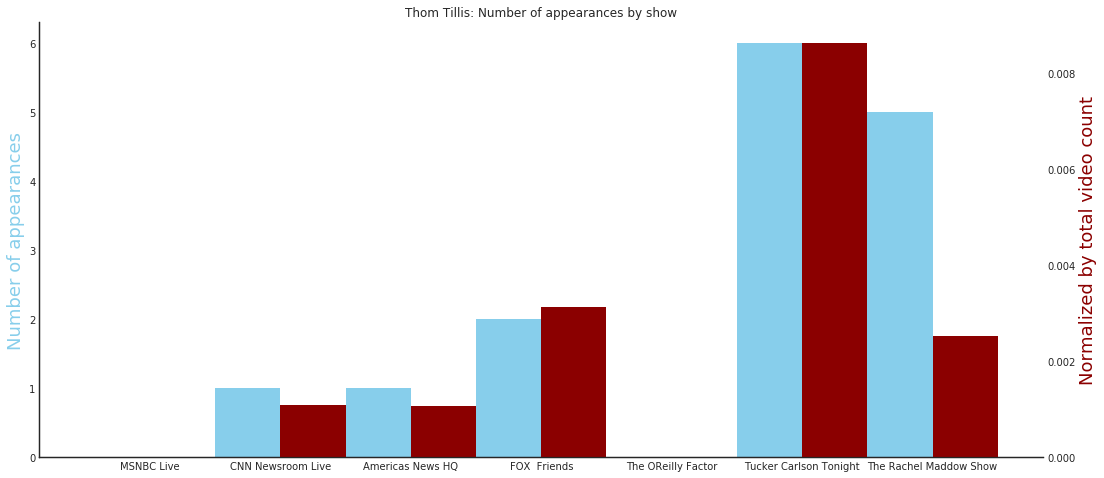

('Tim', 'Kaine') ('U.S. Senate Virginia', 'Democratic Party')


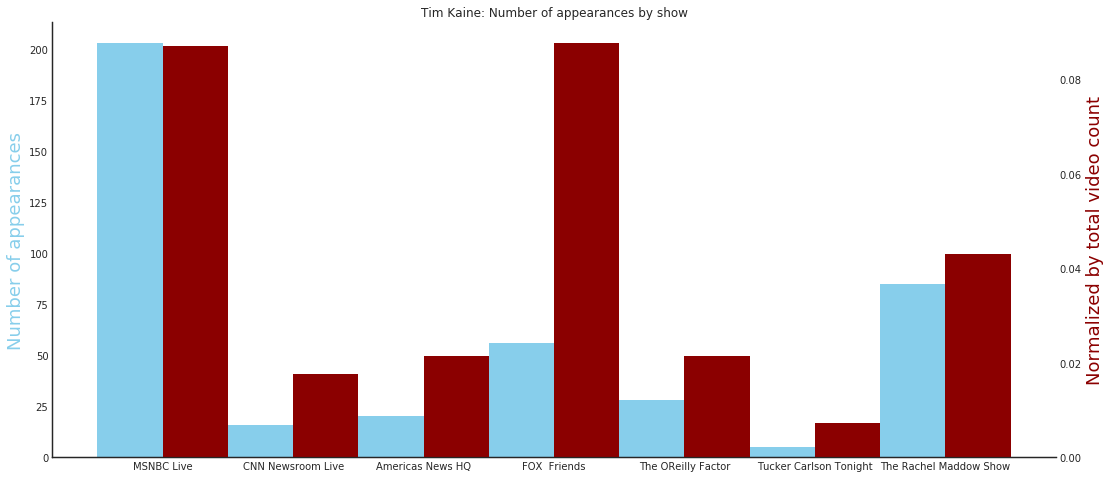

('Tim', 'Scott') ('U.S. Senate South Carolina', 'Republican Party')


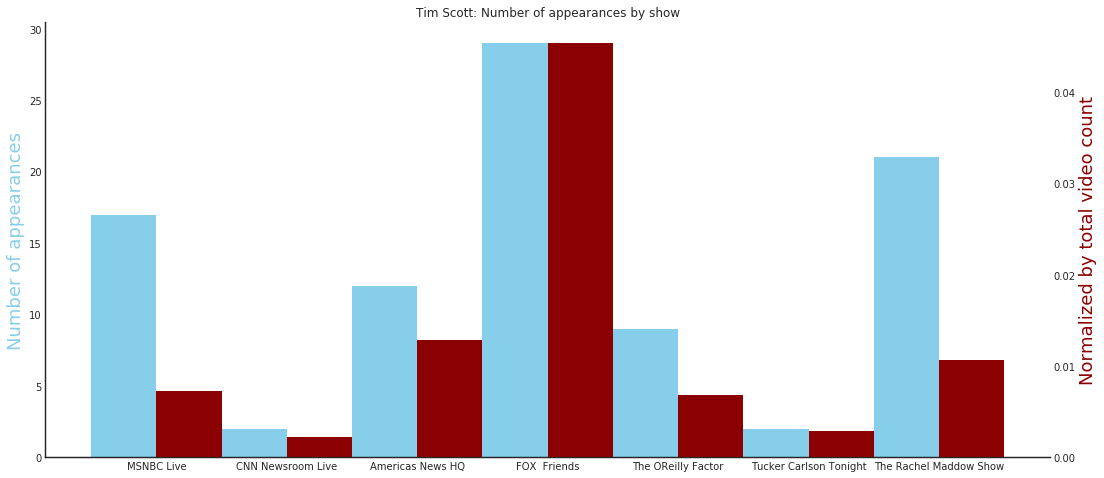

('Tina', 'Smith') ('U.S. Senate Minnesota', 'Democratic Party')


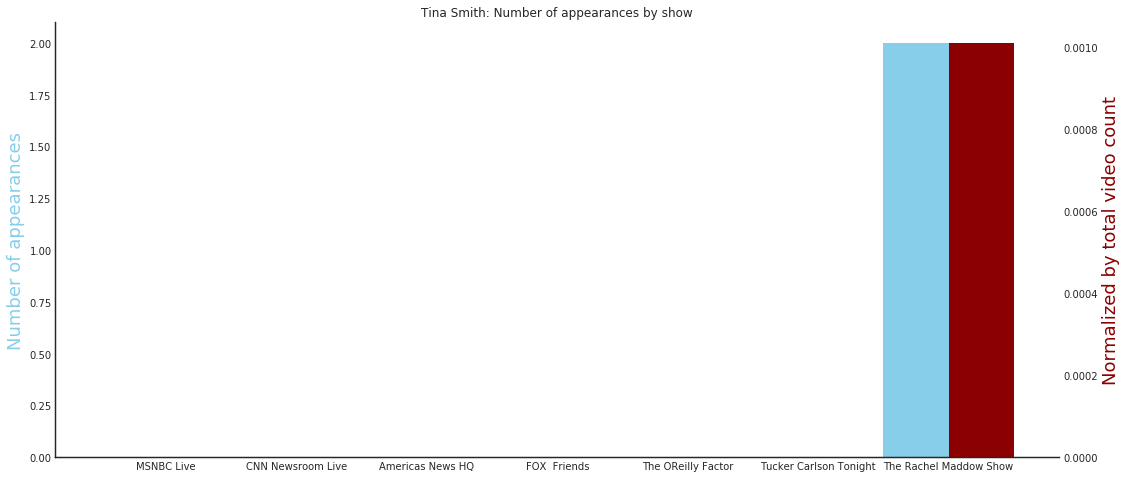

('Todd', 'Young') ('U.S. Senate Indiana', 'Republican Party')


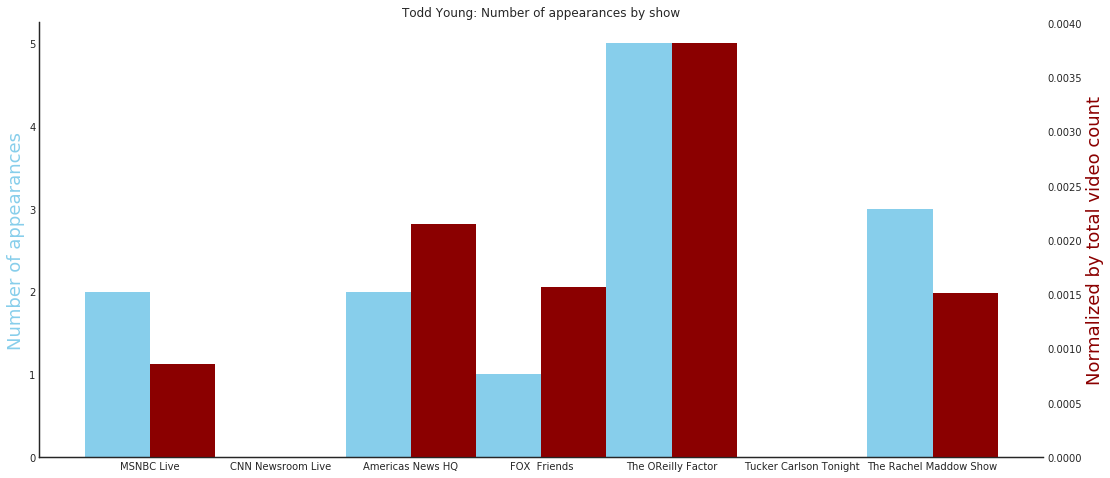

('Tom', 'Carper') ('U.S. Senate Delaware', 'Democratic Party')


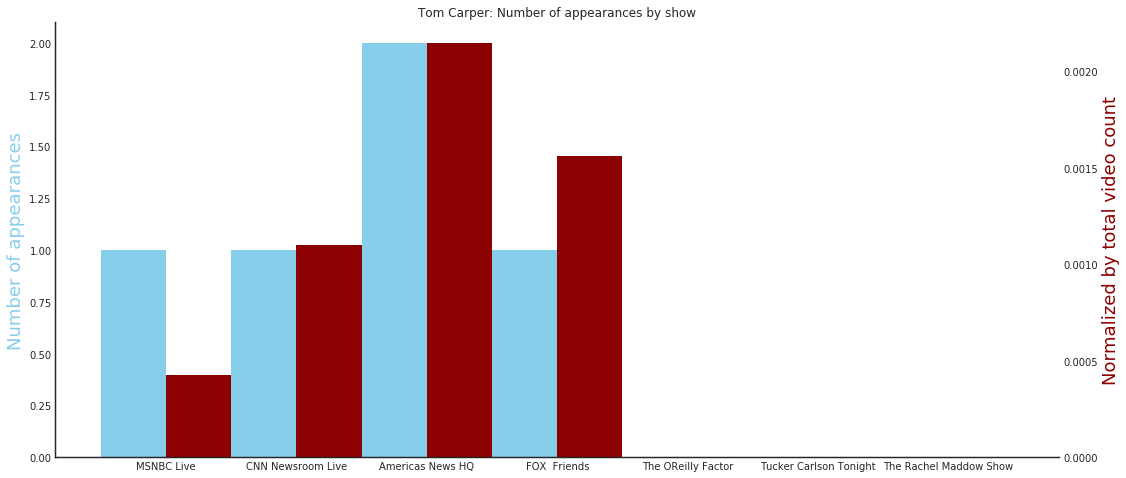

('Tom', 'Cotton') ('U.S. Senate Arkansas', 'Republican Party')


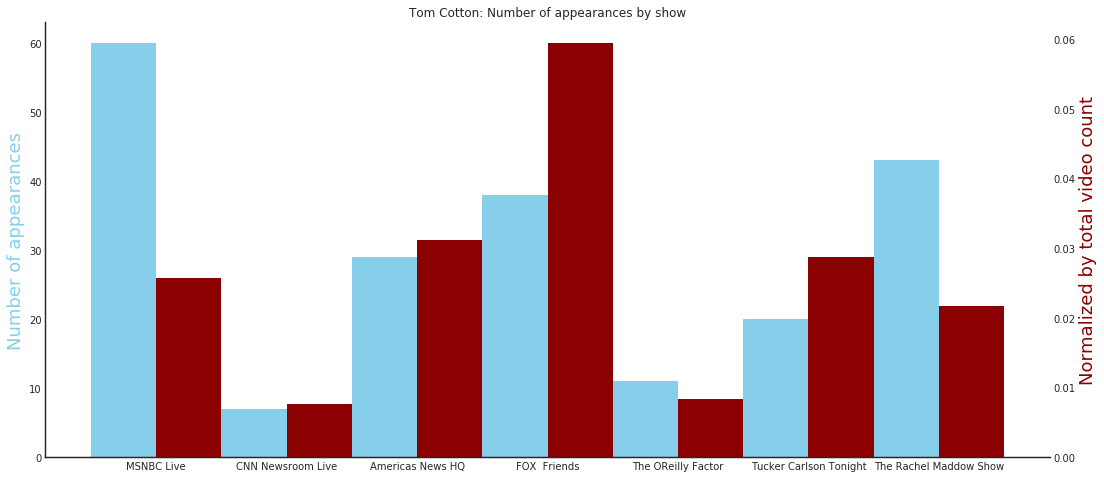

In [ ]:
def plot_for_senator(senator, data):
    fig, ax1 = plt.subplots()
    ind = np.arange(len(data))
    width = 0.5
    rect1 = ax1.bar(ind - width / 2, [y for _, y, _ in data], width,
                    color='SkyBlue', label='Raw number of appearances')
    ax1.set_ylabel('Number of appearances', color='SkyBlue', fontsize=18)
    ax1.set_title('{}: Number of appearances by show'.format(' '.join(senator)))
    ax1.set_xticks(ind)
    ax1.set_xticklabels([x for x, _, _ in data])
    
    ax2 = ax1.twinx()
    rect2 = ax2.bar(ind + width / 2, [float(y)/z for _, y, z in data], width,
                   color='DarkRed', label='Normalized by total video count')
    ax2.set_ylabel('Normalized by total video count', color='DarkRed', fontsize=18)
    
    plt.show()
    
for senator in senators:
    print(senator, senators_meta[senator])
    data = []
    for show_name in shows:
        data.append((show_name, get_count_for_show(show_name, senator_to_videos_ids[senator]),
                     Video.objects.filter(show__name=show_name).count()))
    plot_for_senator(senator, data)